# Идентификация частотного скана сигнала релаксации, состоящего из пяти экспоненциальных составляющих, моноэкспоненциальной моделью

## Импорт необходимых модулей

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

from fsmodels import SklMultiExpFrequencyScan
from fsmodels import SklSingleExpFrequencyScan

from fsplots import plot_spectr
from fsplots import plot_model
from fsplots import plot_loss_path
from fsplots import plot_experimental_points

%matplotlib inline

## Ввод параметров моделирования

In [3]:
N_EXPS = 3

N_SCANS = 31

CENTRAL_TIME_CONSTANT_POWER = -2

DEV = 1.0

F_PULSE = 20 * 10 ** -6


FREQUENCY_POWERS = np.linspace(0, 3.5, 100)

## Расчёт массива параметров моделей частотных сканов

In [4]:
def get_exps_params(n_exps,
                    n_scans,
                    central_time_constant_power,
                    dev,
                    amps = None
                   ):
    
    dev = np.linspace(-dev, dev, n_exps) * np.linspace(0, 1, n_scans).reshape(-1,1)
    time_constant_powers = central_time_constant_power + dev
    
    if amps is None:
        amplitudes = np.ones_like(time_constant_powers)
    else:
        amplitudes = np.array(amps)
        
    exps_params = np.stack([time_constant_powers, amplitudes], axis=-1)
    
    return exps_params

In [5]:
exps_params = get_exps_params(n_exps = N_EXPS,
                n_scans = N_SCANS,
                central_time_constant_power = CENTRAL_TIME_CONSTANT_POWER,
                dev = DEV,
                amps = None
               )

## Расчёт массива тестовых данных (сканов, на которых будет выполняться идентификация модели)

In [6]:
def test_data_prep(exps_params,
                   f_pulse,
                   frequency_powers,
                   n_jobs = 1
                  ):
    
    def get_dlts(params):
        model = SklMultiExpFrequencyScan(n_exps = params.shape[0], 
                                      filling_pulse = f_pulse)
        model.exps_params_ = params
        return model.predict(frequency_powers)
    
    return Parallel(n_jobs=n_jobs)(delayed(get_dlts)(params) for params in exps_params)

In [7]:
test_data = test_data_prep(frequency_powers =FREQUENCY_POWERS,
                           exps_params = exps_params,
                           f_pulse = F_PULSE,
                           n_jobs = -1,
                          )

2022-09-19 07:07:44.235663: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-19 07:07:44.235712: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-19 07:07:44.235719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-19 07:07:44.235913: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-19 07:07:44.235935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-19 07:07:44.235940: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-19 07:07:44.236209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

2022-09-19 07:07:44.452160: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-19 07:07:44.452197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-19 07:07:44.452203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-19 07:07:44.452387: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-19 07:07:44.452405: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-19 07:07:44.452409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-19 07:07:44.452640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

## Идентификация параметров моделей на массиве тестовых данных

In [8]:
def identification(frequency_powers,
                   dlts,
                   f_pulse,
                   learning_rate = 0.05,
                   stop_val = 10**-10,
                  ):
    
    model = SklSingleExpFrequencyScan(filling_pulse = f_pulse, 
                                      learning_rate = learning_rate,
                                      n_iters = 1000,
                                      stop_val = stop_val,
                                      verbose = False,
                                     )
    
    
    model.fit(frequency_powers, dlts)
    
    fit_results = model.fit_results_
    
    return fit_results.iloc[[0], :], fit_results.iloc[[-1], :], fit_results.loss


def batch_identification(test_data,
                         frequency_powers,
                         f_pulse,
                         learning_rate=0.05,
                         stop_val = 10**-10,
                         n_jobs = 1
                        ):
    res = Parallel(n_jobs=n_jobs)(delayed(identification)(frequency_powers, 
                                                          dlts, 
                                                          f_pulse, 
                                                          learning_rate,
                                                          stop_val
                                                         ) for dlts in test_data)

    loss_path = list(zip(*res))[-1]
    res = [frame[:-1] for frame in res]
    
    res = [pd.concat(frame, ignore_index=True) for frame in zip(*res)]
    
    return {'initial_params': res[0], 'final_params': res[1], 'loss_path': loss_path}

In [9]:
identification_results = batch_identification(test_data = test_data,
                                              frequency_powers = FREQUENCY_POWERS, 
                                              f_pulse = F_PULSE,
                                              n_jobs = -1)

In [10]:
def results_to_csv(results, exps_params, filling_pulse, path):
    columns_names = [f'tc_pow_{i}' for i in range(exps_params.shape[1])]
    columns_names += [f'amp_{i}' for i in range(exps_params.shape[1])]
    
    e_params = exps_params.transpose(0,2,1).reshape(-1, exps_params.shape[1]*exps_params.shape[2])
    
    res = results.copy()
    res[columns_names] = e_params
    
    res['filling_pulse'] = filling_pulse
    res['n_exps'] = exps_params.shape[1]
    
    res.to_csv(path, index=False)
    return res

## Сохранение результатов идентификации

In [11]:
results_to_csv(results=identification_results['final_params'],
               exps_params=exps_params,
               filling_pulse=F_PULSE,
               path='../models/3-exp-clear/models_parameters.csv')

amplitude_0  filling_pulse  fit_p_coef  learning_rate          loss  \
0      2.999859        0.00002        True           0.05  3.559912e-09   
1      2.995592        0.00002        True           0.05  4.758275e-07   
2      2.982877        0.00002        True           0.05  7.471207e-06   
3      2.961960        0.00002        True           0.05  3.708133e-05   
4      2.933236        0.00002        True           0.05  1.140592e-04   
5      2.897230        0.00002        True           0.05  2.689950e-04   
6      2.854573        0.00002        True           0.05  5.348600e-04   
7      2.805975        0.00002        True           0.05  9.433149e-04   
8      2.752192        0.00002        True           0.05  1.521172e-03   
9      2.694006        0.00002        True           0.05  2.287350e-03   
10     2.632190        0.00002        True           0.05  3.250580e-03   
11     2.567500        0.00002        True           0.05  4.408020e-03   
12     2.500644        0.00002        True           0.05  5.744861e-03   
13     2.432286        0.00002        True           0.05  7.234897e-03   
14     2.363031        0.00002        True           0.05  8.841977e-03   
15     2.293424        0.00002        True           0.05  1.052219e-02   
16     2.223942        0.00002        True           0.05  1.222657e-02   
17     2.155014        0.00002        True           0.05  1.390411e-02   
18     2.086991        0.00002        True           0.05  1.550479e-02   
19     2.020177        0.00002        True           0.05  1.698231e-02   
20     1.954811        0.00002        True           0.05  1.829650e-02   
21     1.891078        0.00002        True           0.05  1.941491e-02   
22     1.829106        0.00002        True           0.05  2.031386e-02   
23     1.768974        0.00002        True           0.05  2.097877e-02   
24     1.710717        0.00002        True           0.05  2.140392e-02   
25     1.654337        0.00002        True           0.05  2.159189e-02   
26     1.599799        0.00002        True           0.05  2.155275e-02   
27     1.547055        0.00002        True           0.05  2.130319e-02   
28     1.496050        0.00002        True           0.05  2.086566e-02   
29     1.446716        0.00002        True           0.05  2.026756e-02   
30     1.398972        0.00002        True           0.05  1.954048e-02   

    n_exps  n_iters    p_coef      stop_val  time_constant_pow_0  verbose  \
0        3     1000  0.999919  1.000000e-10            -2.000000    False   
1        3     1000  0.997250  1.000000e-10            -2.000003    False   
2        3     1000  0.989316  1.000000e-10            -2.000008    False   
3        3     1000  0.976325  1.000000e-10            -1.999999    False   
4        3     1000  0.958611  1.000000e-10            -1.999953    False   
5        3     1000  0.936607  1.000000e-10            -1.999837    False   
6        3     1000  0.910826  1.000000e-10            -1.999610    False   
7        3     1000  0.881825  1.000000e-10            -1.999226    False   
8        3     1000  0.850185  1.000000e-10            -1.998632    False   
9        3     1000  0.816480  1.000000e-10            -1.997772    False   
10       3     1000  0.781253  1.000000e-10            -1.996589    False   
11       3     1000  0.745015  1.000000e-10            -1.995027    False   
12       3     1000  0.708216  1.000000e-10            -1.993031    False   
13       3     1000  0.671257  1.000000e-10            -1.990554    False   
14       3     1000  0.634482  1.000000e-10            -1.987555    False   
15       3     1000  0.598179  1.000000e-10            -1.984008    False   
16       3     1000  0.562585  1.000000e-10            -1.979897    False   
17       3     1000  0.527897  1.000000e-10            -1.975227    False   
18       3     1000  0.494261  1.000000e-10            -1.970019    False   
19       3     1000  0.461788  1.000000e-10            -1.96431

## Вывод графиков на экран

In [12]:
def batch_plot(frequency_powers, 
               experimental_values, 
               exps_params,
               identification_results,
               f_pulse,
               save_to=None
              ):
    
    for i in range(exps_params.shape[0]):
        print(f'Спектр № {i}')
        print(f'exps_params:\n{exps_params[i]}')
        print(f"Результаты идентификации:\n{identification_results['final_params'].iloc[[i], :]}")
        
        plot_spectr(exps_params[i])
        
        if save_to is not None:
            plt.savefig(save_to + 'spectr' + f'{i}' + '.pdf', bbox_inches='tight')
        
        plt.show()
        
        res = pd.concat([identification_results['initial_params'].iloc[[i], :],
                         identification_results['final_params'].iloc[[i], :]
                        ])
        
        plot_model(X=frequency_powers,
                   y=experimental_values[i],
                   model_class=SklSingleExpFrequencyScan, 
                   fit_results_=res,
                   plot_exps=False
                  )
        
        if save_to is not None:
            plt.savefig(save_to + 'identification_results_' + f'{i}' + '.pdf', bbox_inches='tight')
            
        plot_loss_path(pd.DataFrame({'loss':identification_results['loss_path'][i]}))
        if save_to is not None:
            plt.savefig(save_to + 'loss_path_' + f'{i}' + '.pdf', bbox_inches='tight')
            
        plt.show()

Спектр № 0
exps_params:
[[-2.  1.]
 [-2.  1.]
 [-2.  1.]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate          loss  \
0     2.999859        0.00002        True           0.05  3.559912e-09   

   n_exps  n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
0       1     1000  0.999919  1.000000e-10                 -2.0    False  


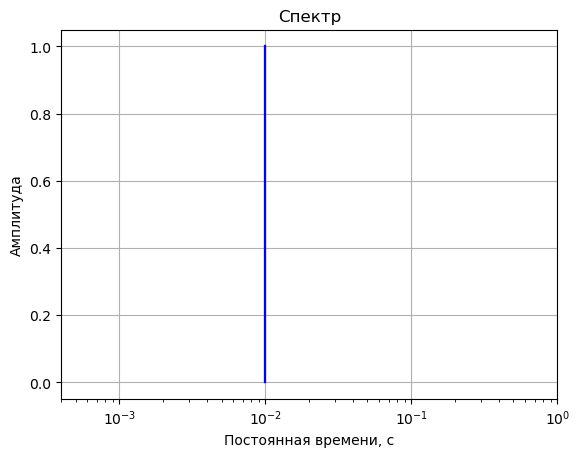

2022-09-19 07:11:11.639836: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-19 07:11:11.639856: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aleksei-B550I
2022-09-19 07:11:11.639860: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aleksei-B550I
2022-09-19 07:11:11.639939: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-19 07:11:11.639951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-19 07:11:11.639954: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-19 07:11:11.640099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instru

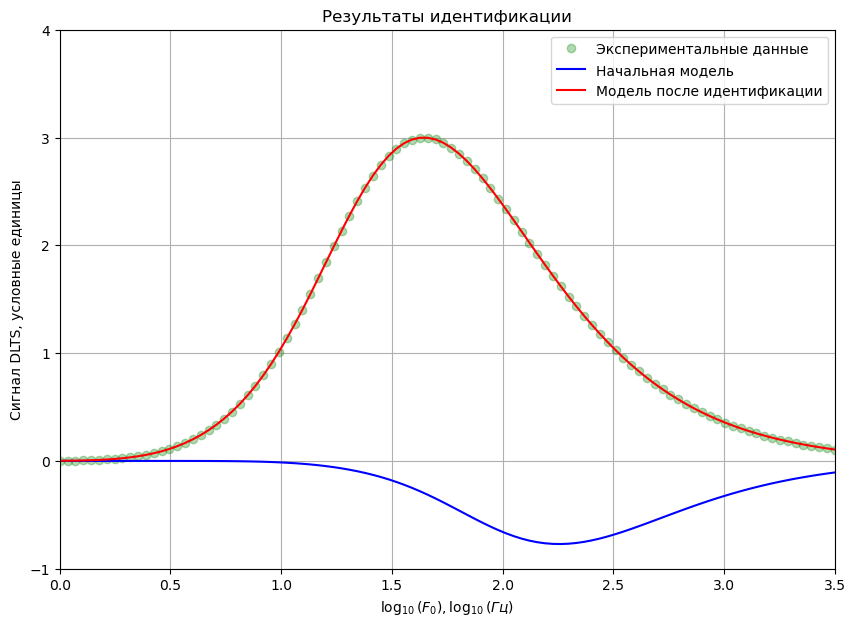

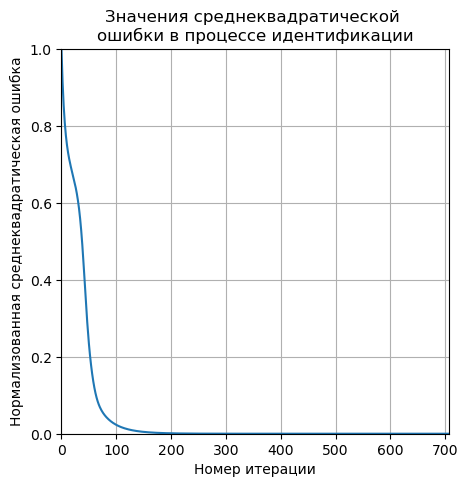

Спектр № 1
exps_params:
[[-2.03333333  1.        ]
 [-2.          1.        ]
 [-1.96666667  1.        ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate          loss  \
1     2.995592        0.00002        True           0.05  4.758275e-07   

   n_exps  n_iters   p_coef      stop_val  time_constant_pow_0  verbose  
1       1     1000  0.99725  1.000000e-10            -2.000003    False  


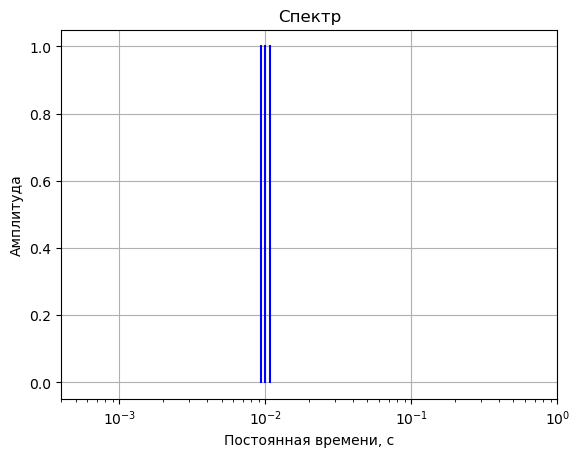

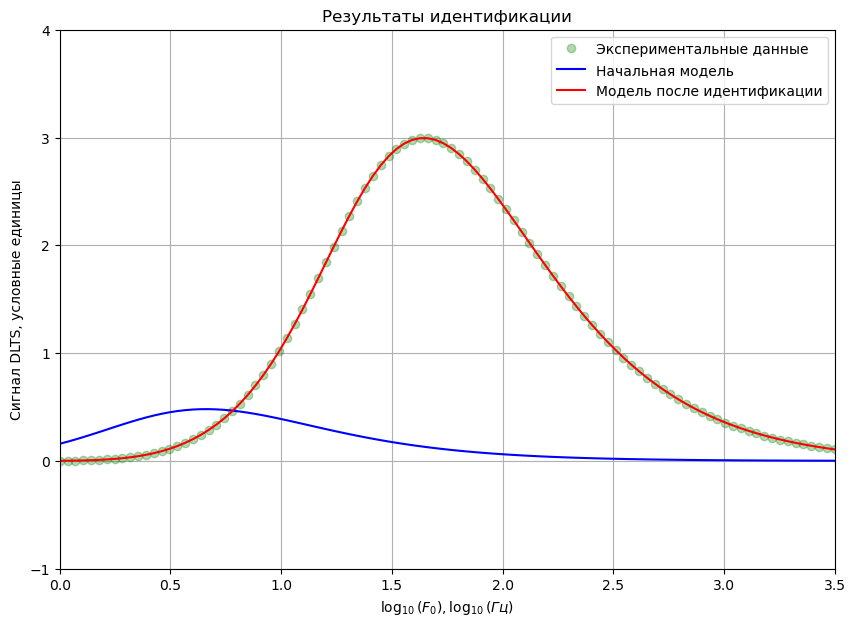

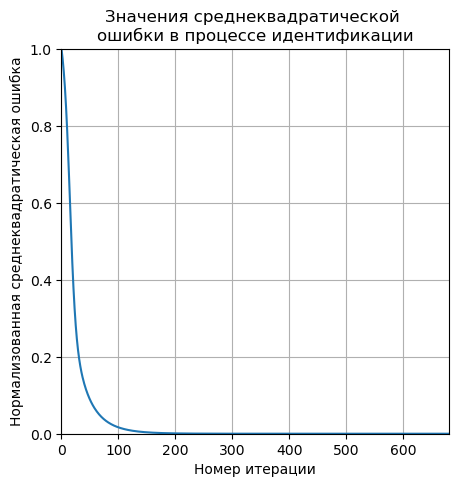

Спектр № 2
exps_params:
[[-2.06666667  1.        ]
 [-2.          1.        ]
 [-1.93333333  1.        ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
2     2.982877        0.00002        True           0.05  0.000007       1   

   n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
2     1000  0.989316  1.000000e-10            -2.000008    False  


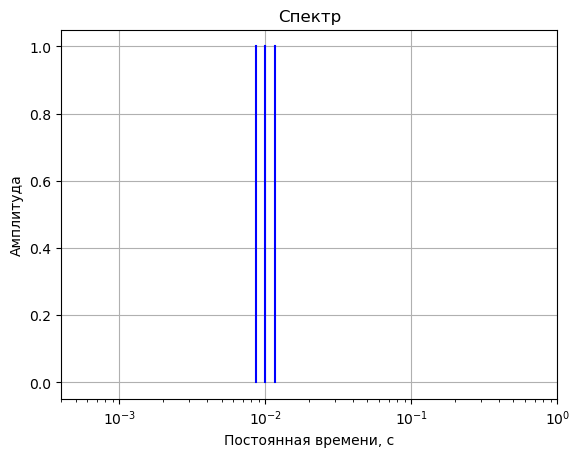

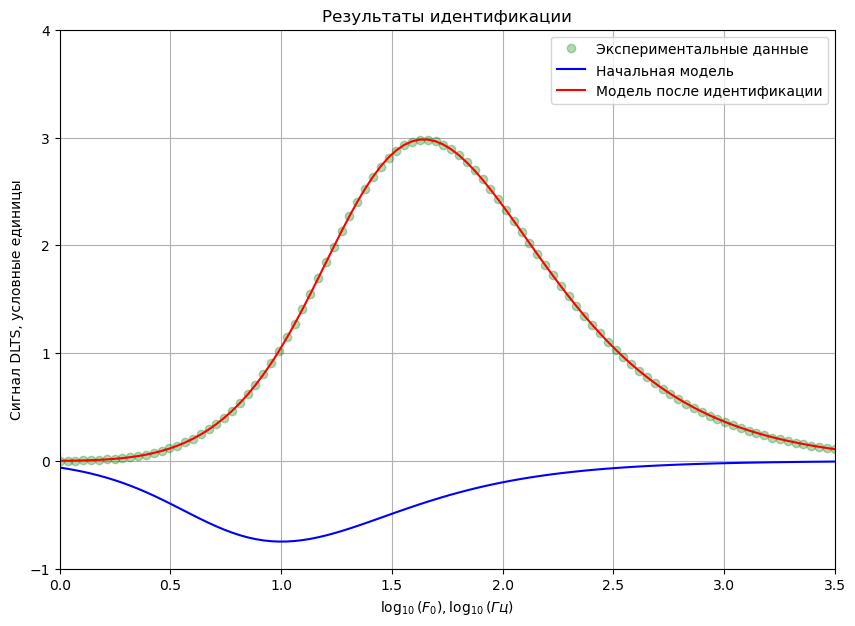

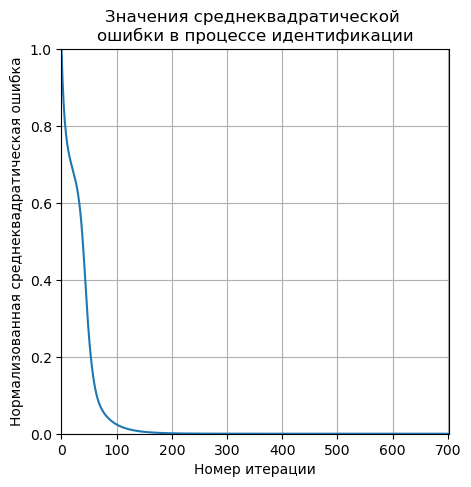

Спектр № 3
exps_params:
[[-2.1  1. ]
 [-2.   1. ]
 [-1.9  1. ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
3      2.96196        0.00002        True           0.05  0.000037       1   

   n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
3     1000  0.976325  1.000000e-10            -1.999999    False  


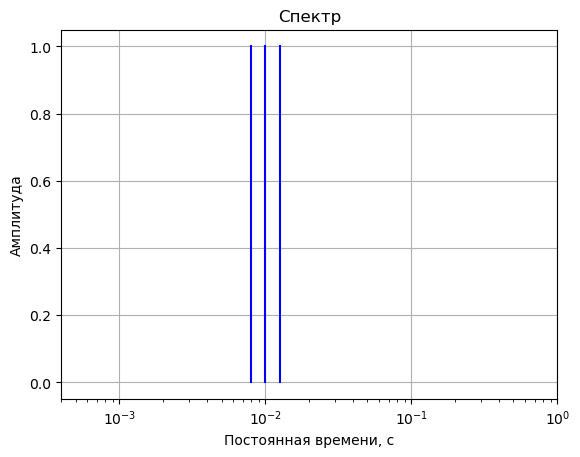

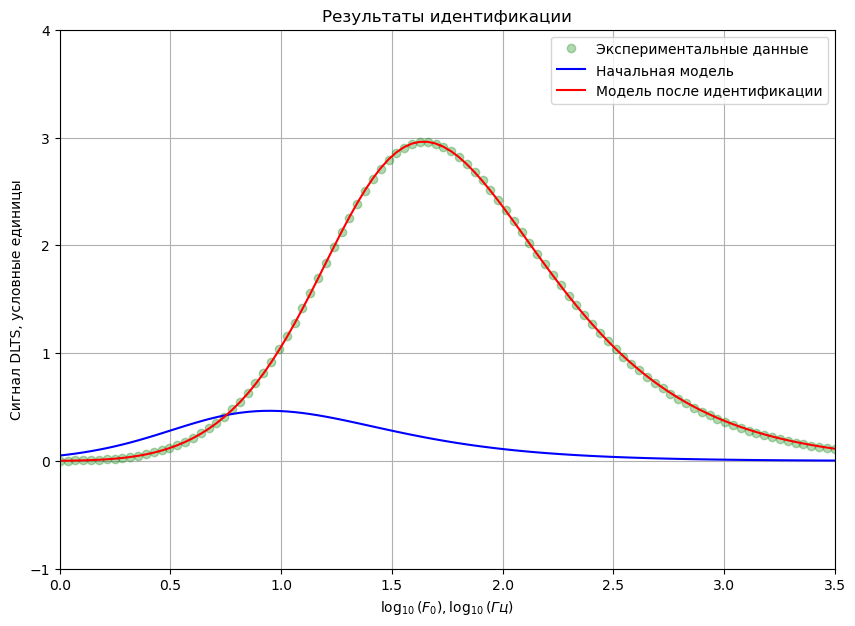

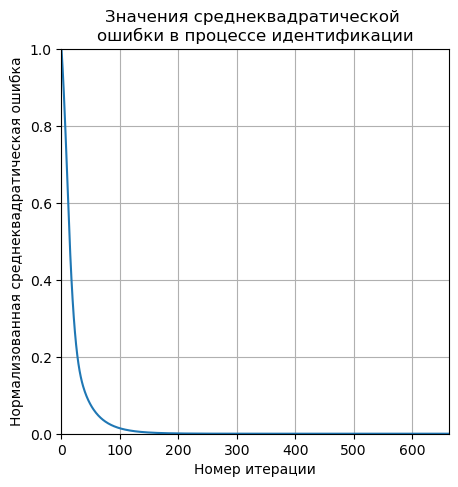

Спектр № 4
exps_params:
[[-2.13333333  1.        ]
 [-2.          1.        ]
 [-1.86666667  1.        ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
4     2.933236        0.00002        True           0.05  0.000114       1   

   n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
4     1000  0.958611  1.000000e-10            -1.999953    False  


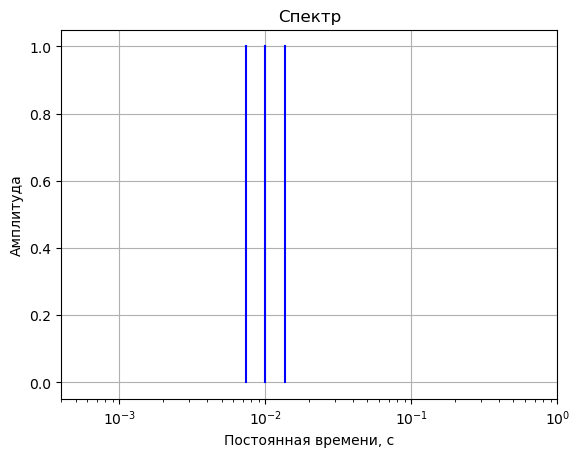

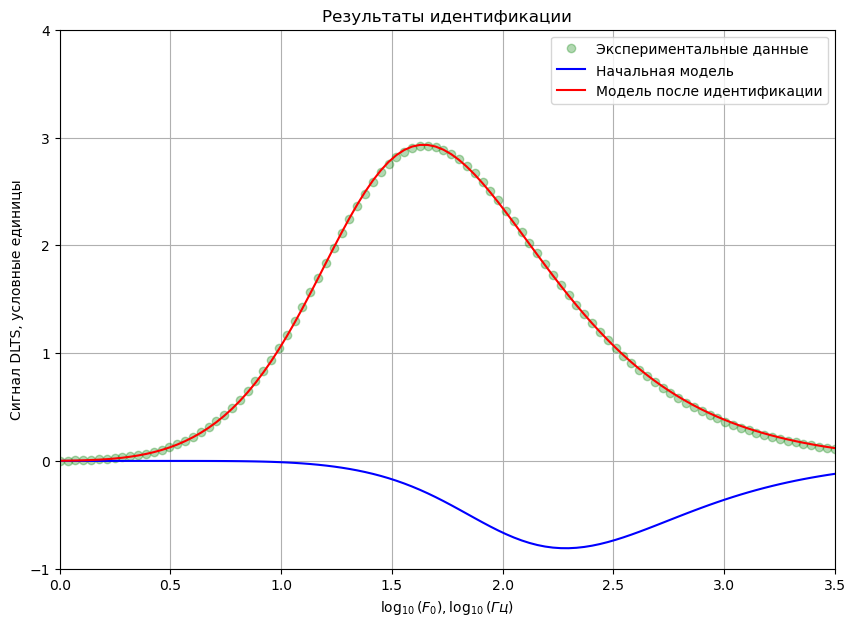

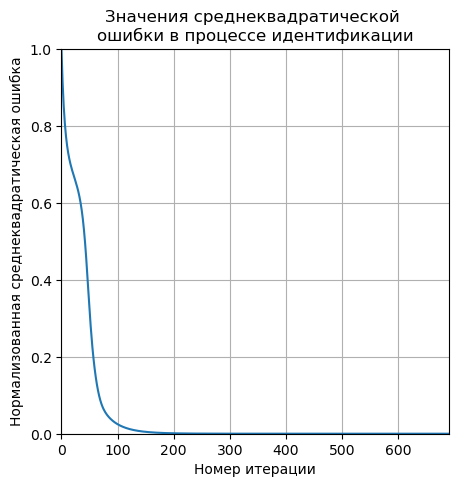

Спектр № 5
exps_params:
[[-2.16666667  1.        ]
 [-2.          1.        ]
 [-1.83333333  1.        ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
5      2.89723        0.00002        True           0.05  0.000269       1   

   n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
5     1000  0.936607  1.000000e-10            -1.999837    False  


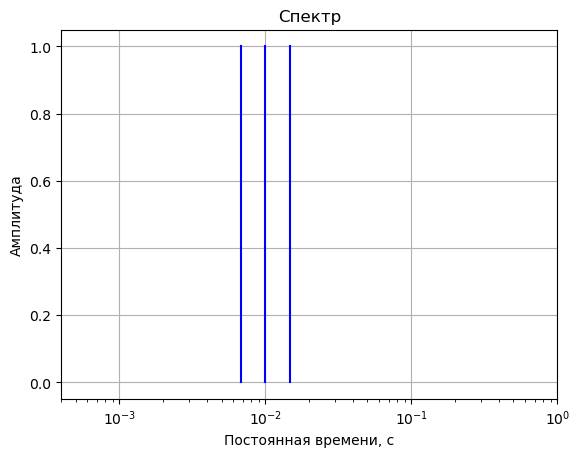

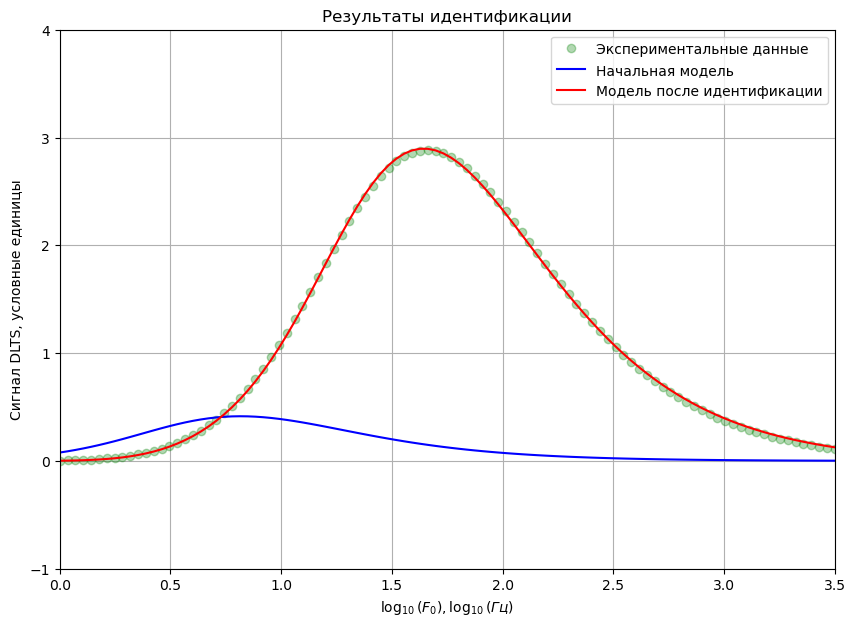

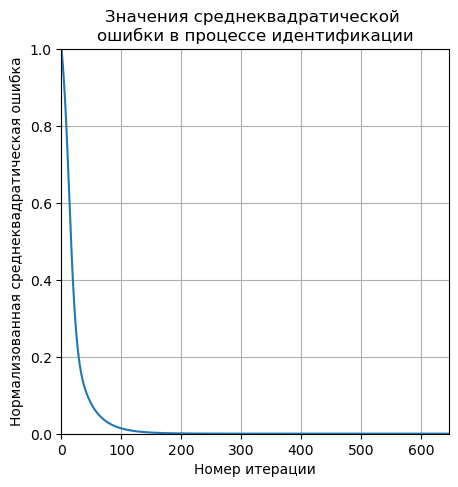

Спектр № 6
exps_params:
[[-2.2  1. ]
 [-2.   1. ]
 [-1.8  1. ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
6     2.854573        0.00002        True           0.05  0.000535       1   

   n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
6     1000  0.910826  1.000000e-10             -1.99961    False  


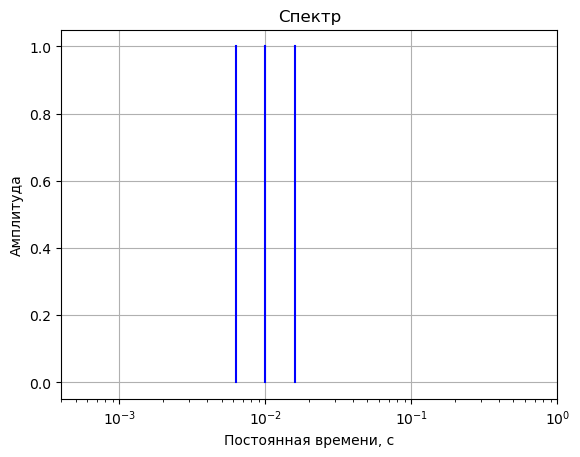

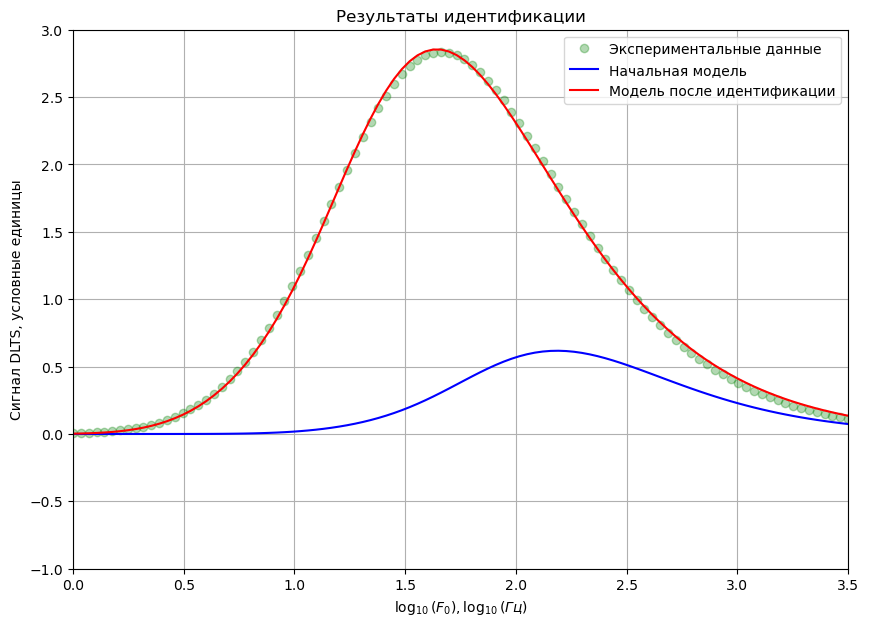

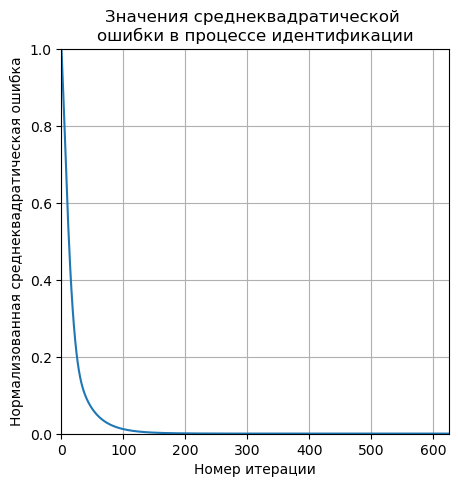

Спектр № 7
exps_params:
[[-2.23333333  1.        ]
 [-2.          1.        ]
 [-1.76666667  1.        ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
7     2.805975        0.00002        True           0.05  0.000943       1   

   n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
7     1000  0.881825  1.000000e-10            -1.999226    False  


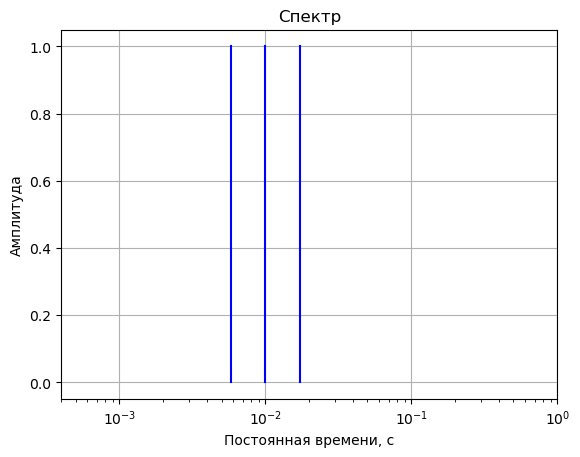

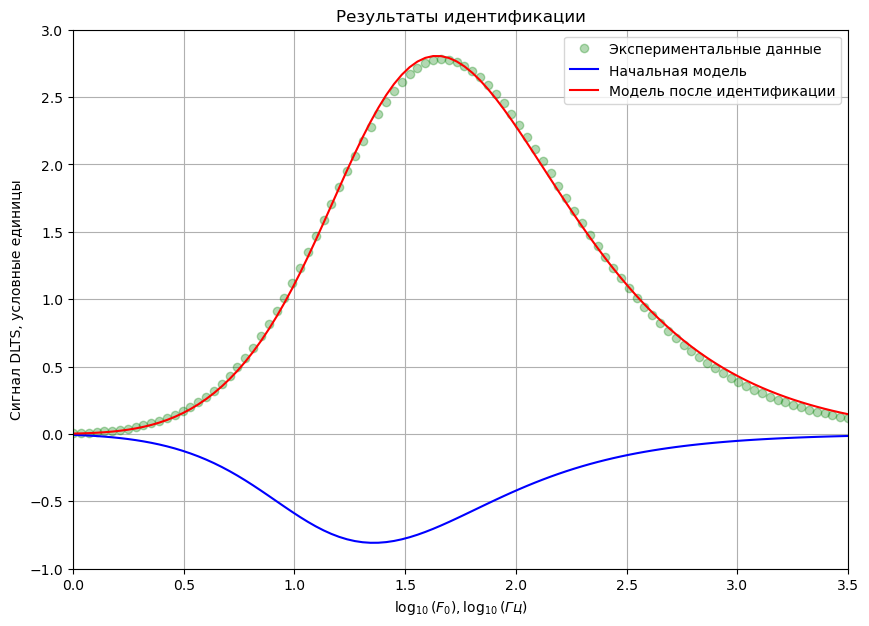

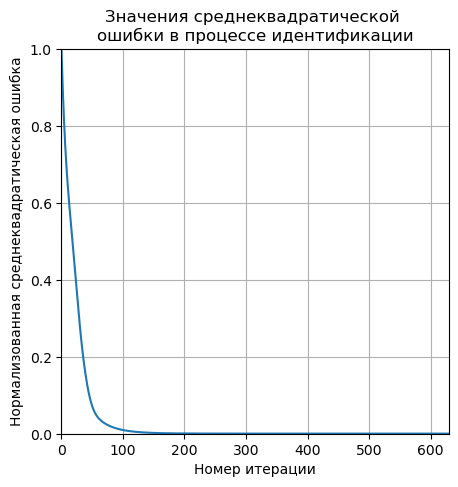

Спектр № 8
exps_params:
[[-2.26666667  1.        ]
 [-2.          1.        ]
 [-1.73333333  1.        ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
8     2.752192        0.00002        True           0.05  0.001521       1   

   n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
8     1000  0.850185  1.000000e-10            -1.998632    False  


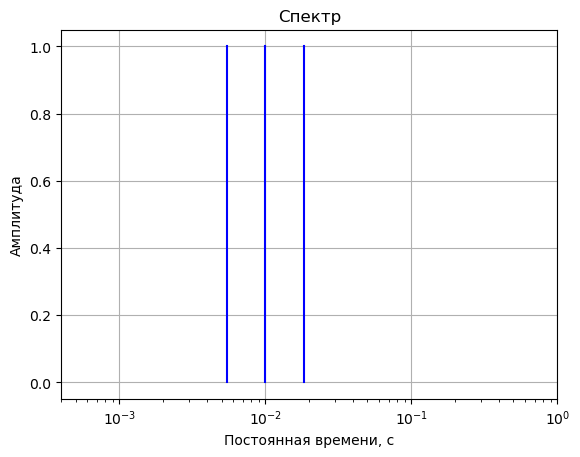

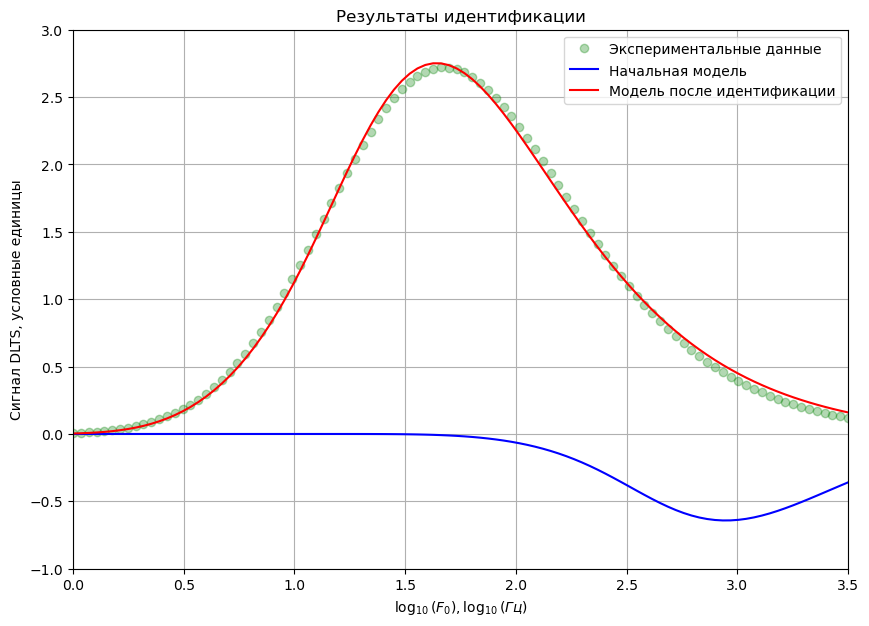

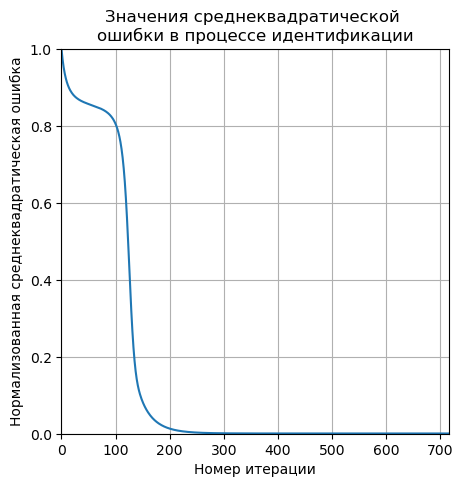

Спектр № 9
exps_params:
[[-2.3  1. ]
 [-2.   1. ]
 [-1.7  1. ]]
Результаты идентификации:
   amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
9     2.694006        0.00002        True           0.05  0.002287       1   

   n_iters   p_coef      stop_val  time_constant_pow_0  verbose  
9     1000  0.81648  1.000000e-10            -1.997772    False  


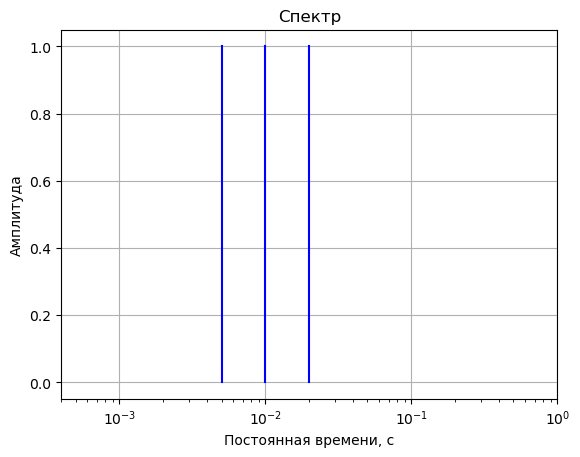

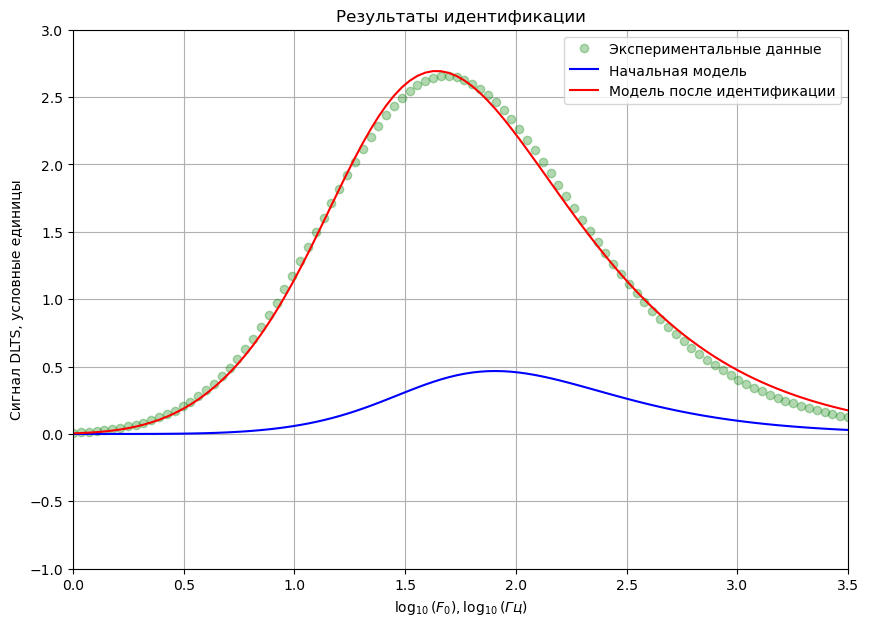

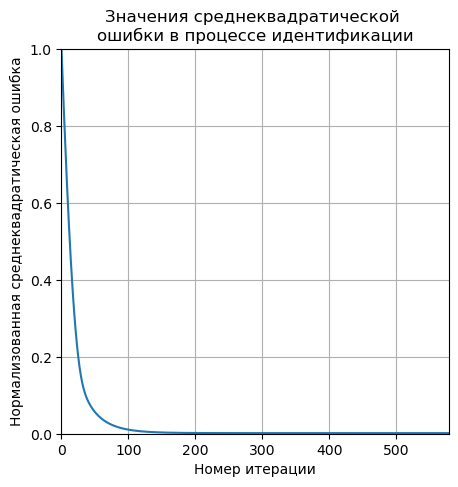

Спектр № 10
exps_params:
[[-2.33333333  1.        ]
 [-2.          1.        ]
 [-1.66666667  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
10      2.63219        0.00002        True           0.05  0.003251       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
10     1000  0.781253  1.000000e-10            -1.996589    False  


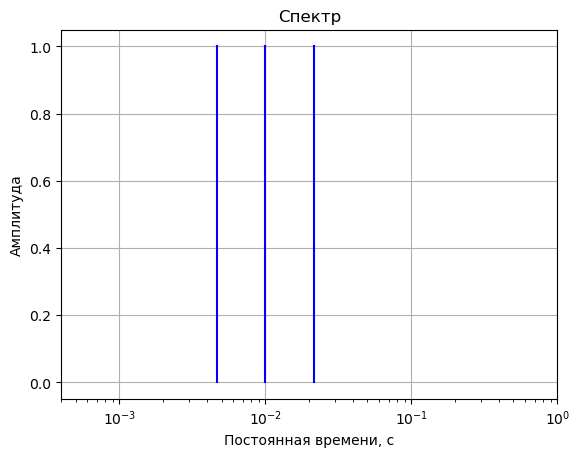

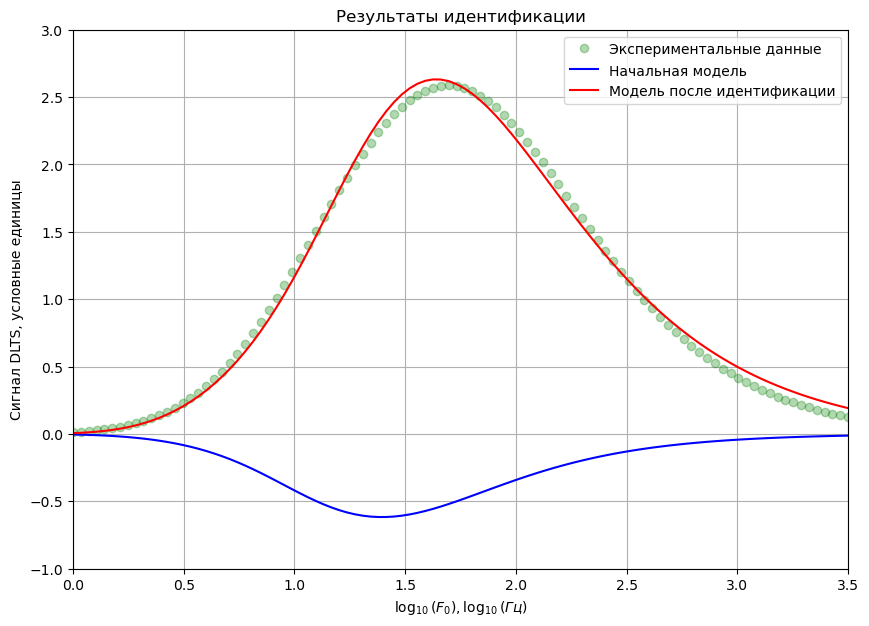

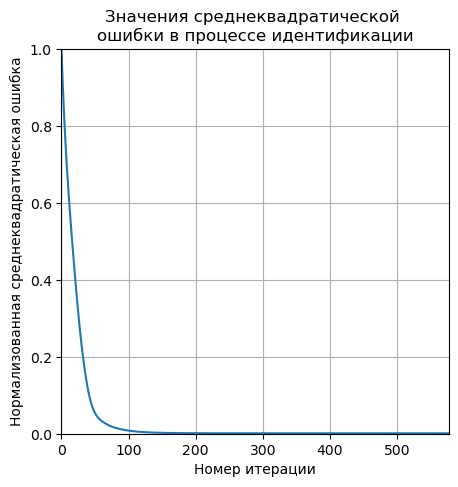

Спектр № 11
exps_params:
[[-2.36666667  1.        ]
 [-2.          1.        ]
 [-1.63333333  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
11       2.5675        0.00002        True           0.05  0.004408       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
11     1000  0.745015  1.000000e-10            -1.995027    False  


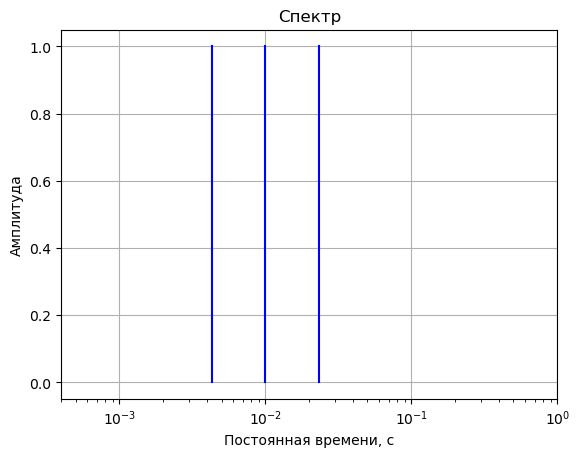

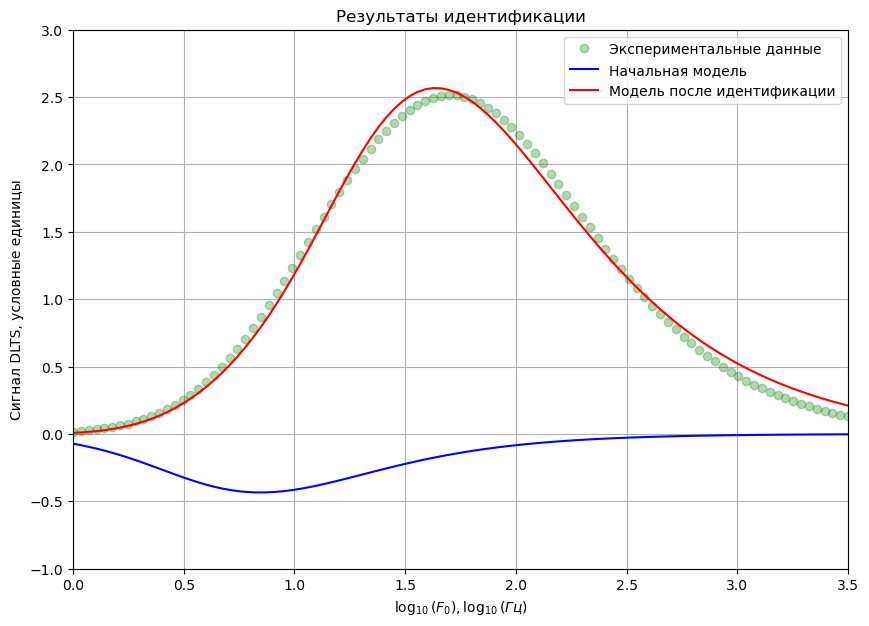

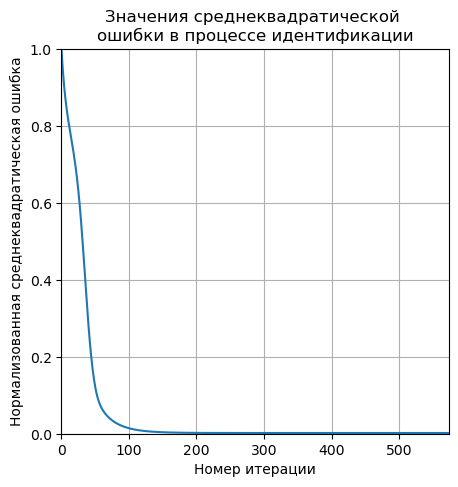

Спектр № 12
exps_params:
[[-2.4  1. ]
 [-2.   1. ]
 [-1.6  1. ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
12     2.500644        0.00002        True           0.05  0.005745       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
12     1000  0.708216  1.000000e-10            -1.993031    False  


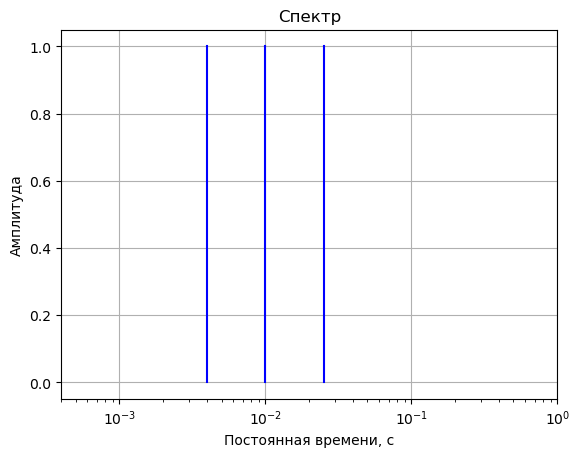

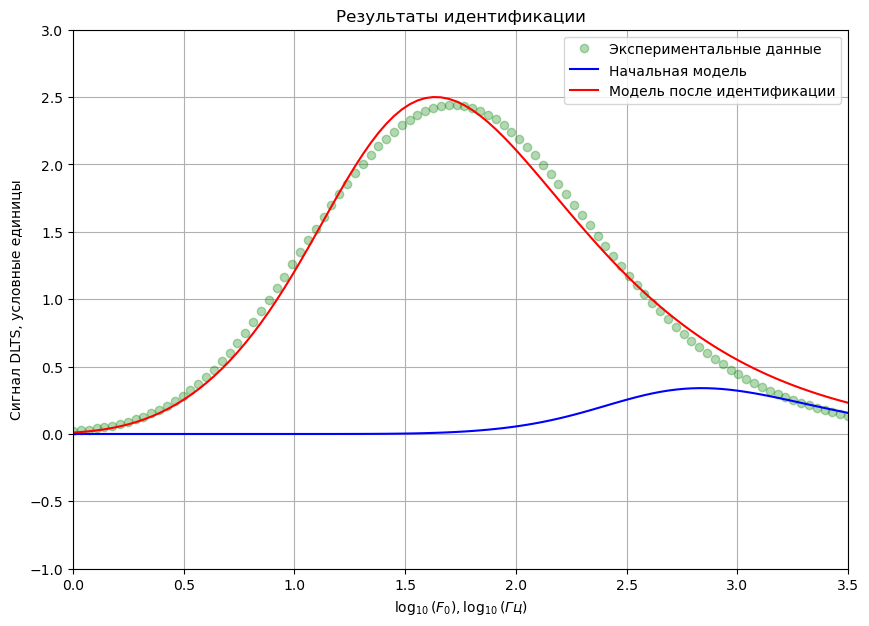

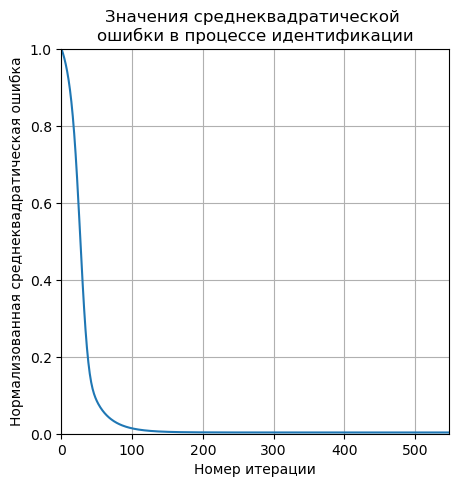

Спектр № 13
exps_params:
[[-2.43333333  1.        ]
 [-2.          1.        ]
 [-1.56666667  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
13     2.432286        0.00002        True           0.05  0.007235       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
13     1000  0.671257  1.000000e-10            -1.990554    False  


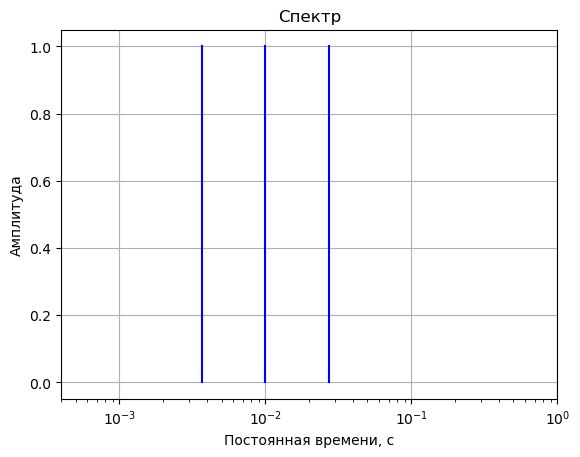

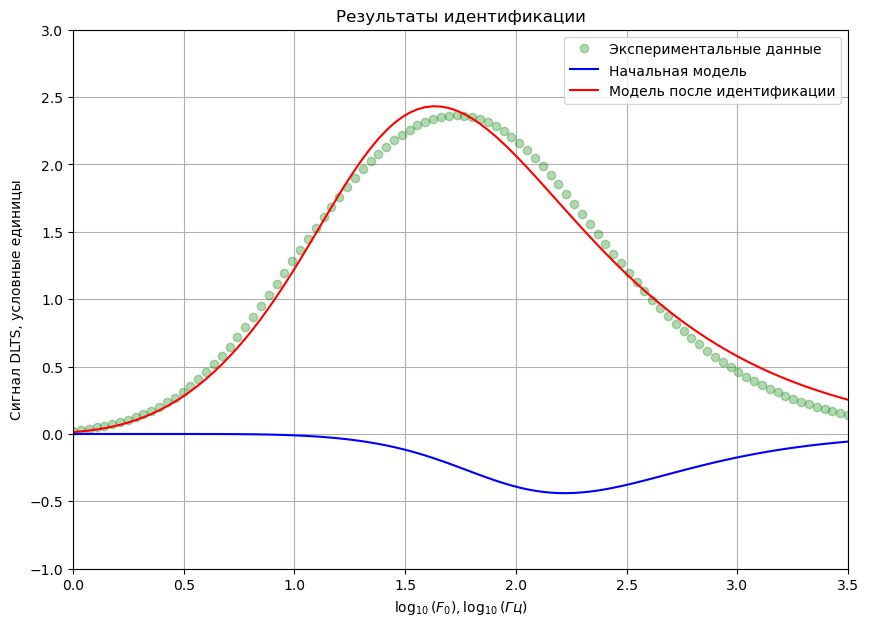

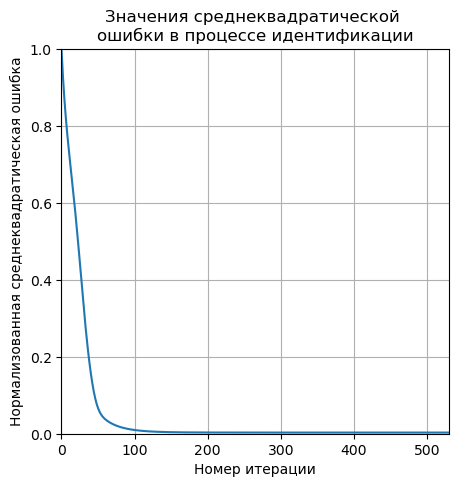

Спектр № 14
exps_params:
[[-2.46666667  1.        ]
 [-2.          1.        ]
 [-1.53333333  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
14     2.363031        0.00002        True           0.05  0.008842       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
14     1000  0.634482  1.000000e-10            -1.987555    False  


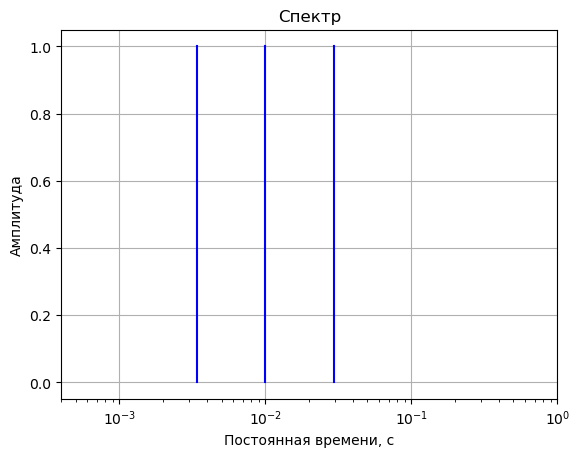

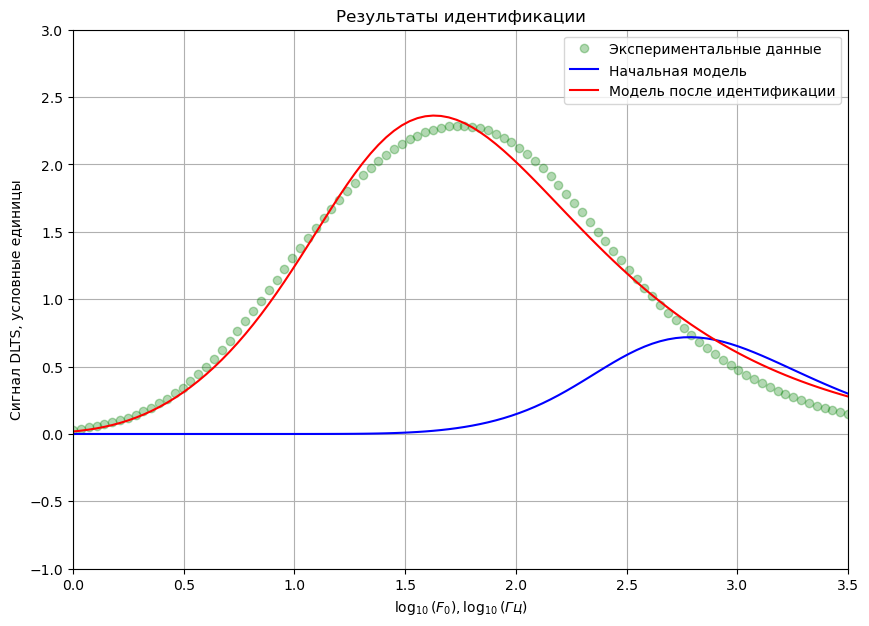

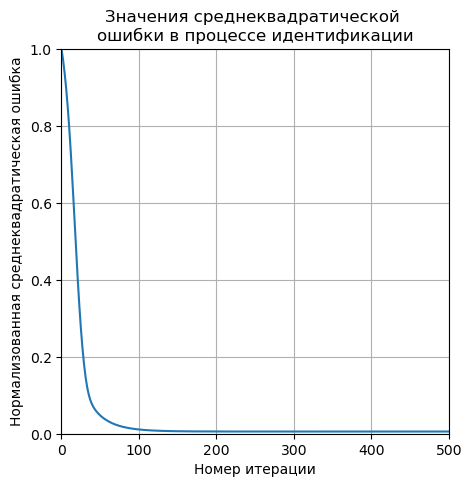

Спектр № 15
exps_params:
[[-2.5  1. ]
 [-2.   1. ]
 [-1.5  1. ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
15     2.293424        0.00002        True           0.05  0.010522       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
15     1000  0.598179  1.000000e-10            -1.984008    False  


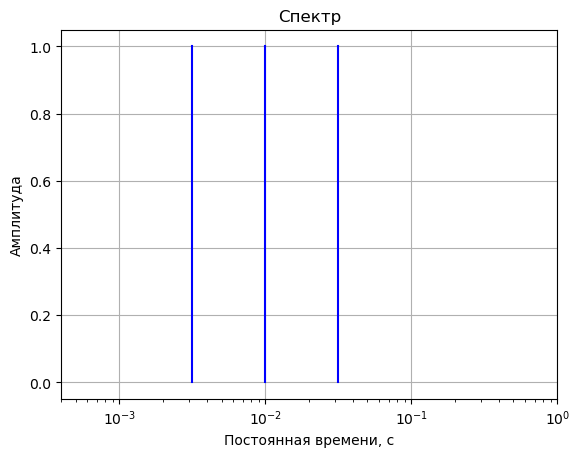

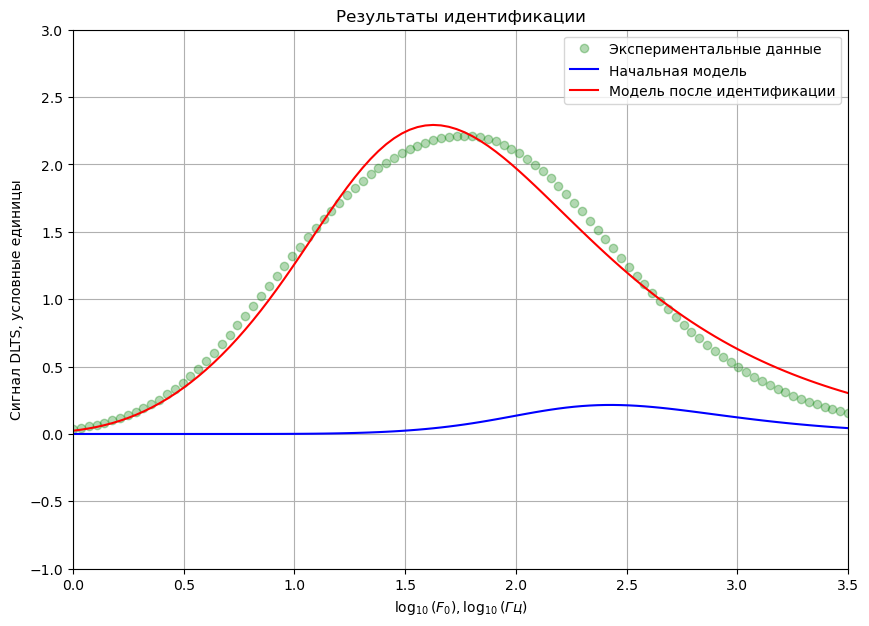

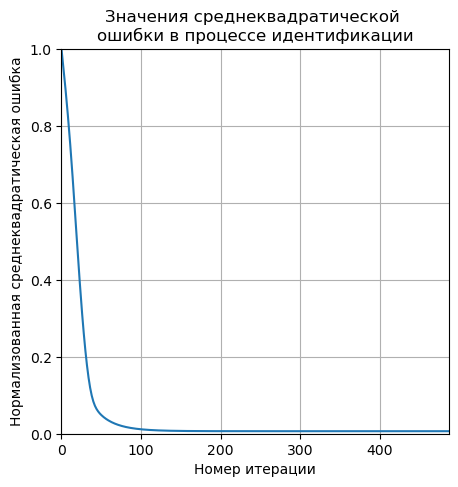

Спектр № 16
exps_params:
[[-2.53333333  1.        ]
 [-2.          1.        ]
 [-1.46666667  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
16     2.223942        0.00002        True           0.05  0.012227       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
16     1000  0.562585  1.000000e-10            -1.979897    False  


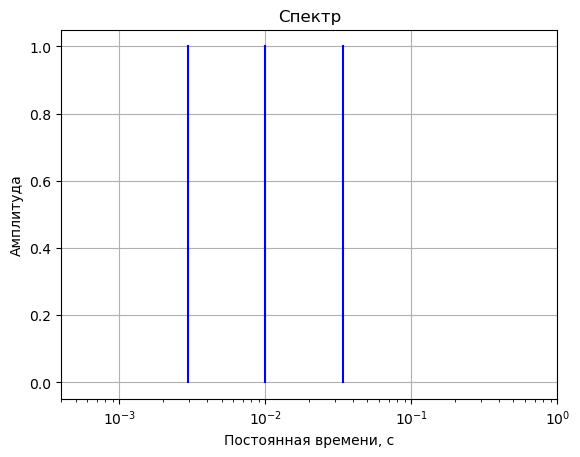

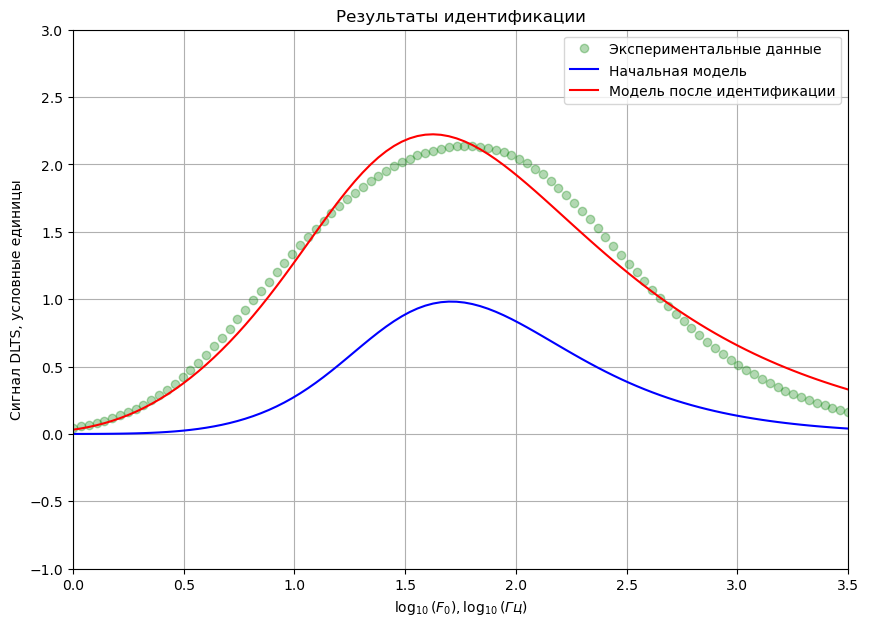

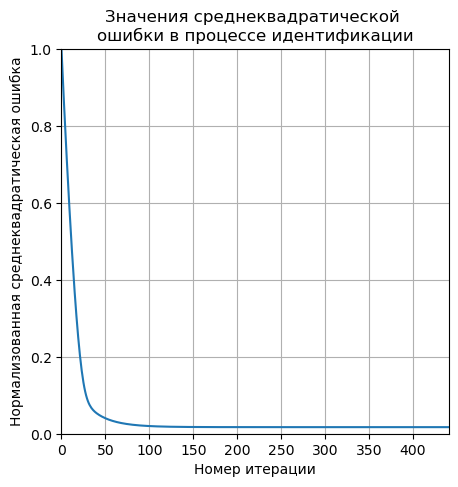

Спектр № 17
exps_params:
[[-2.56666667  1.        ]
 [-2.          1.        ]
 [-1.43333333  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
17     2.155014        0.00002        True           0.05  0.013904       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
17     1000  0.527897  1.000000e-10            -1.975227    False  


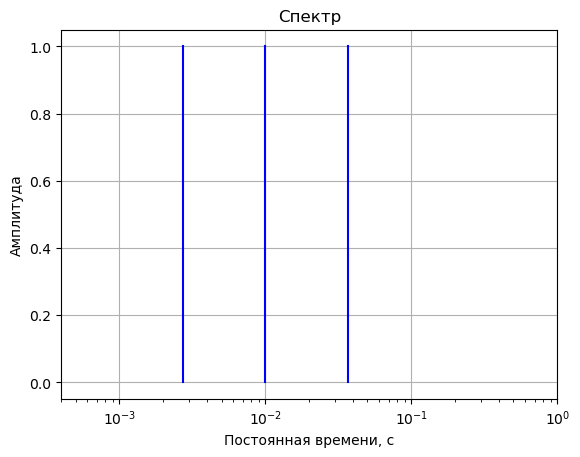

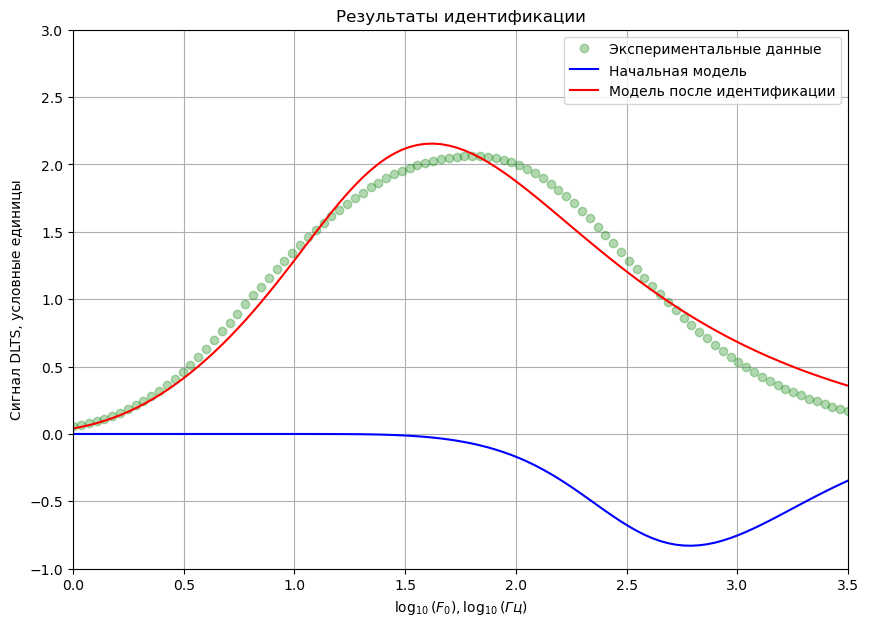

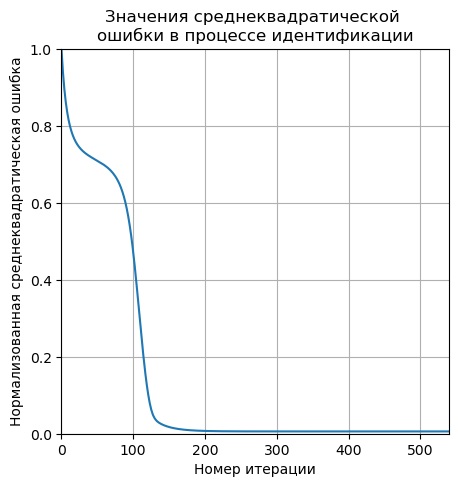

Спектр № 18
exps_params:
[[-2.6  1. ]
 [-2.   1. ]
 [-1.4  1. ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
18     2.086991        0.00002        True           0.05  0.015505       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
18     1000  0.494261  1.000000e-10            -1.970019    False  


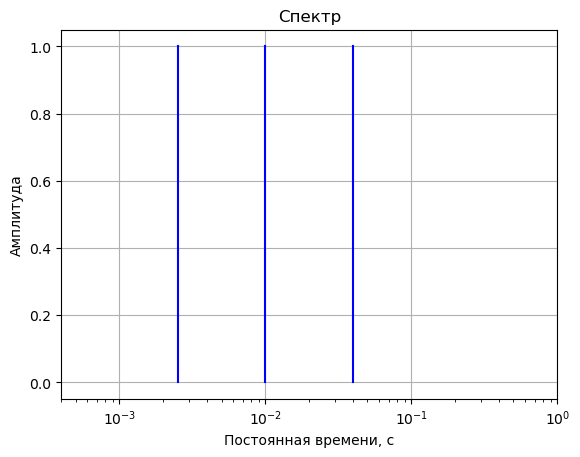

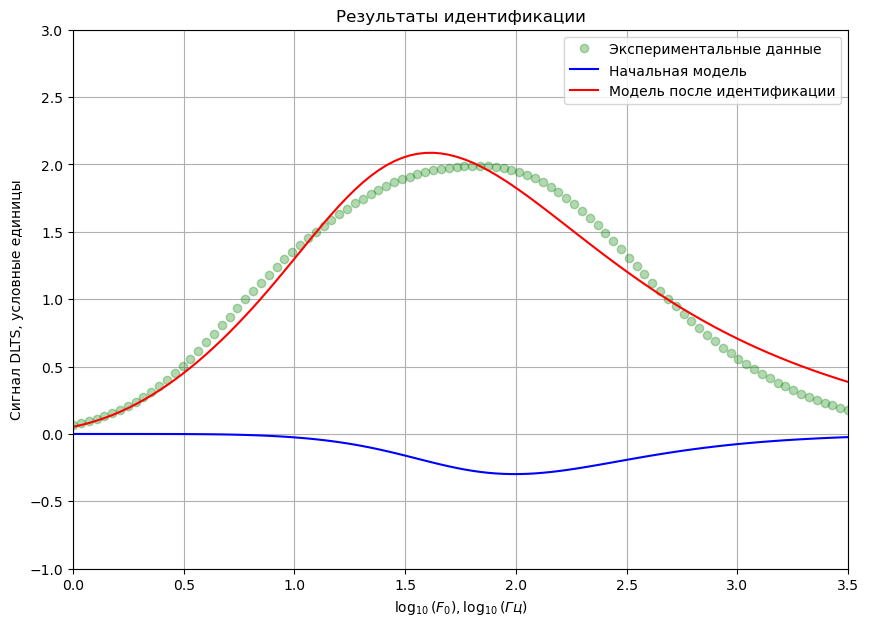

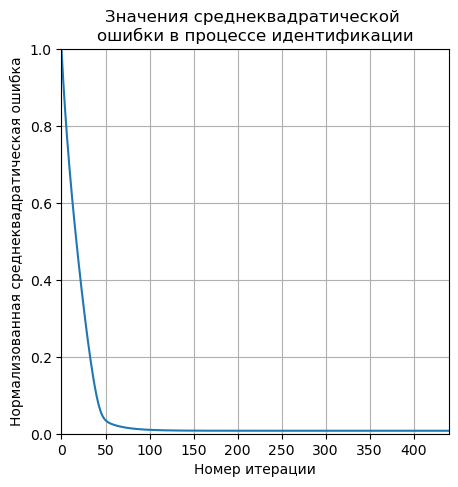

Спектр № 19
exps_params:
[[-2.63333333  1.        ]
 [-2.          1.        ]
 [-1.36666667  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
19     2.020177        0.00002        True           0.05  0.016982       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
19     1000  0.461788  1.000000e-10            -1.964313    False  


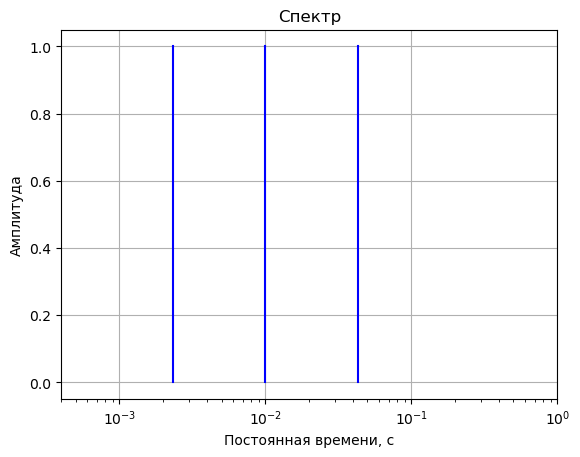

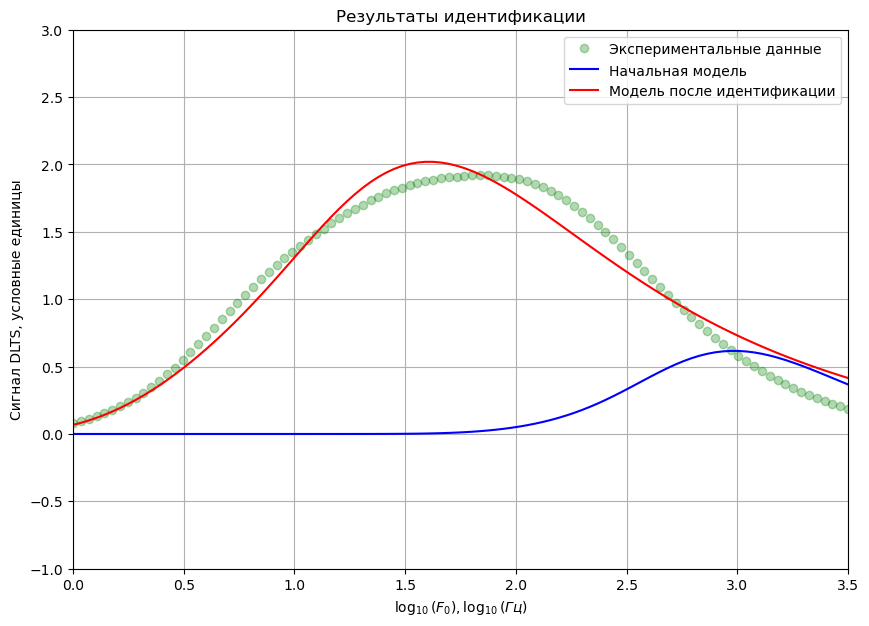

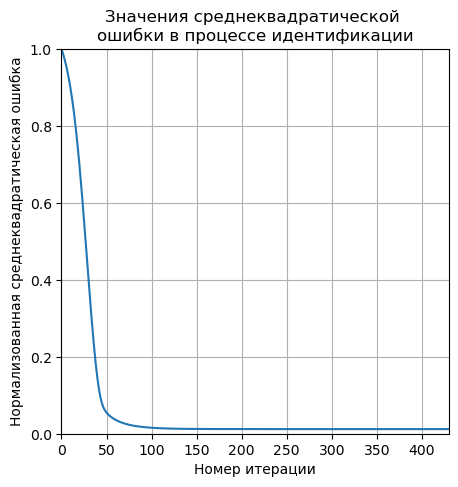

Спектр № 20
exps_params:
[[-2.66666667  1.        ]
 [-2.          1.        ]
 [-1.33333333  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
20     1.954811        0.00002        True           0.05  0.018296       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
20     1000  0.430552  1.000000e-10            -1.958165    False  


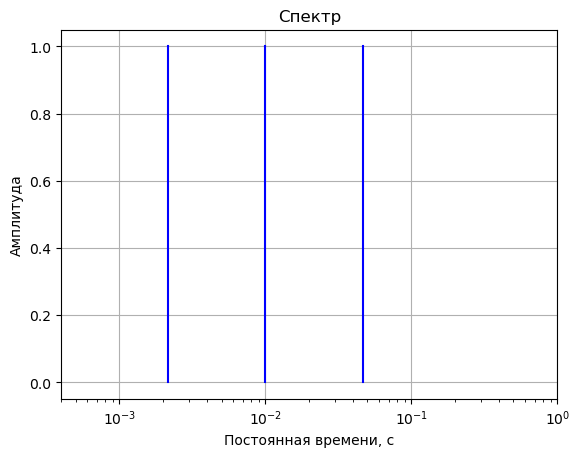

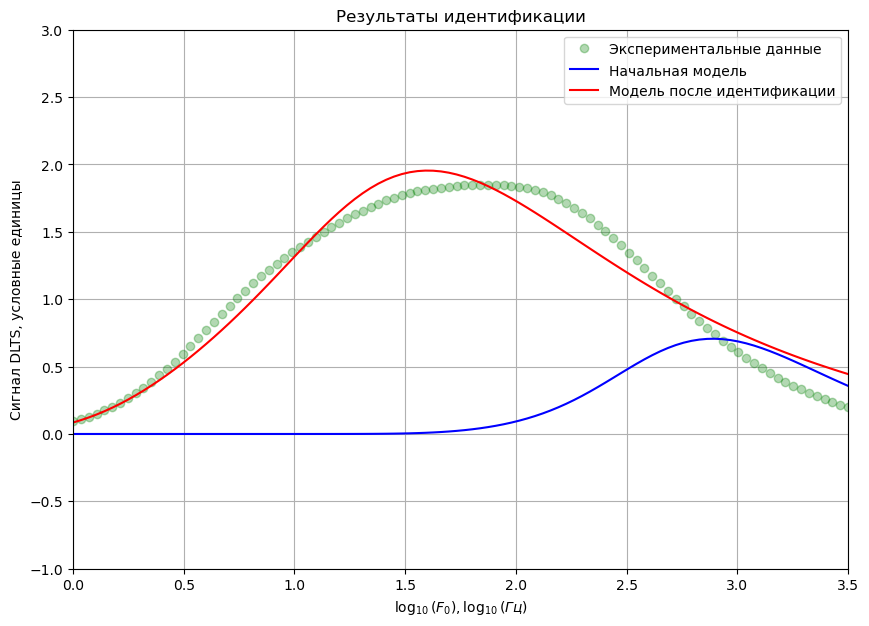

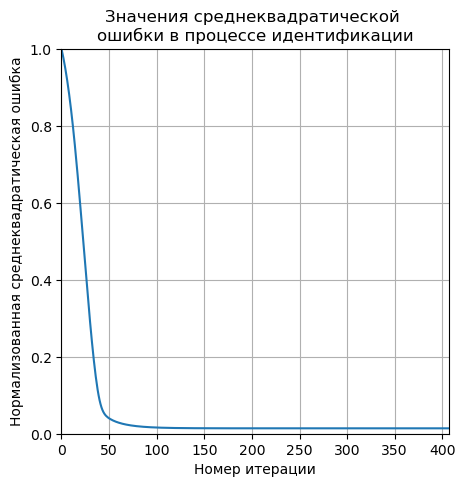

Спектр № 21
exps_params:
[[-2.7  1. ]
 [-2.   1. ]
 [-1.3  1. ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
21     1.891078        0.00002        True           0.05  0.019415       1   

    n_iters   p_coef      stop_val  time_constant_pow_0  verbose  
21     1000  0.40059  1.000000e-10            -1.951644    False  


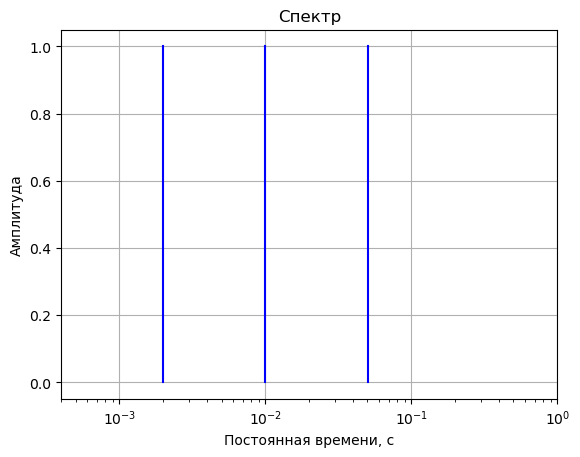

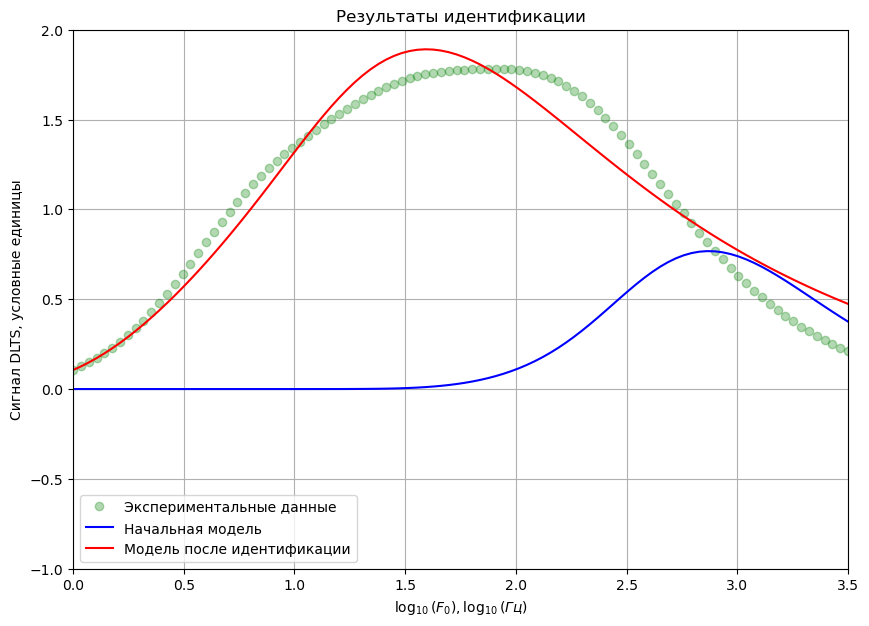

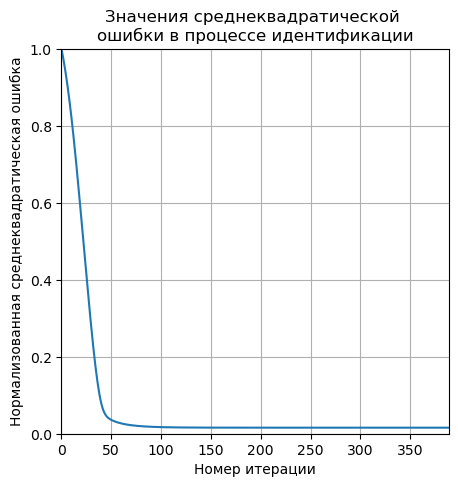

Спектр № 22
exps_params:
[[-2.73333333  1.        ]
 [-2.          1.        ]
 [-1.26666667  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
22     1.829106        0.00002        True           0.05  0.020314       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
22     1000  0.371911  1.000000e-10            -1.944831    False  


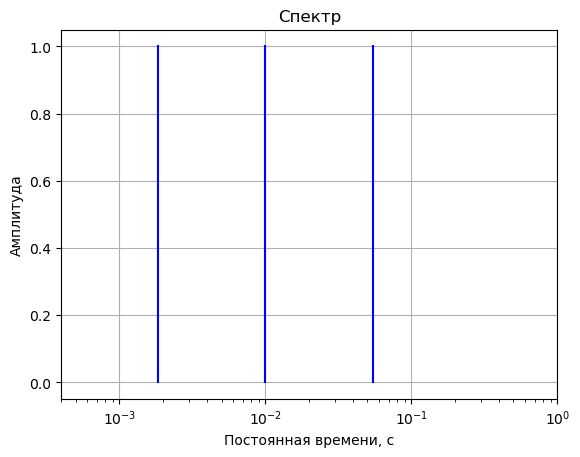

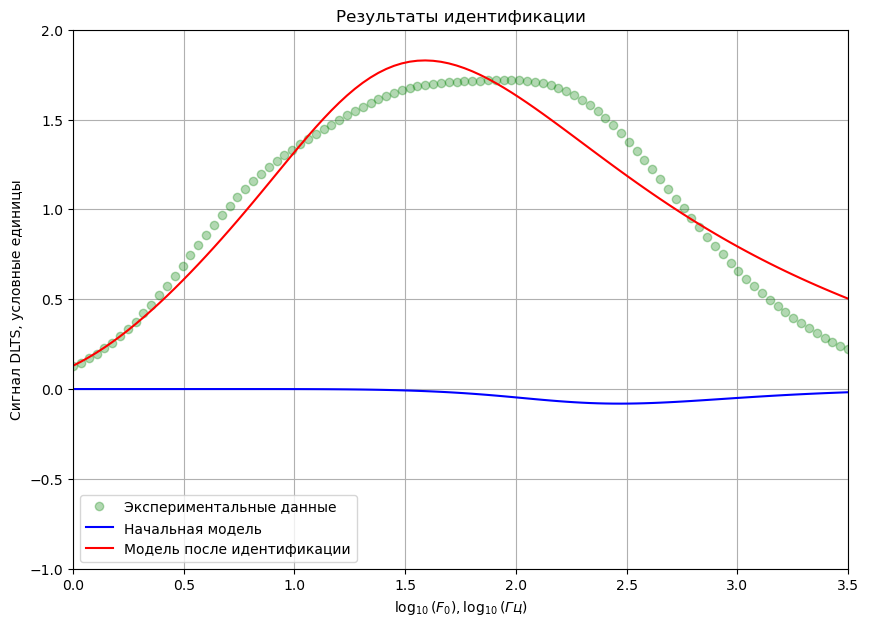

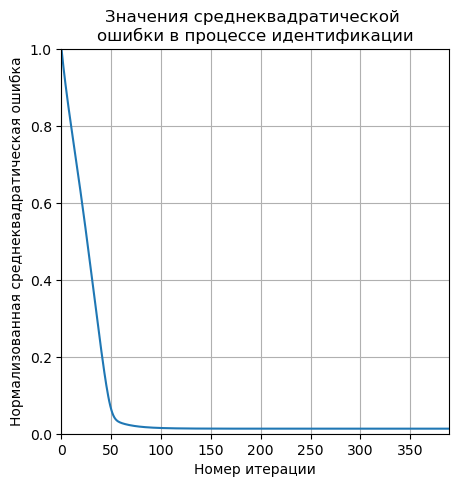

Спектр № 23
exps_params:
[[-2.76666667  1.        ]
 [-2.          1.        ]
 [-1.23333333  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
23     1.768974        0.00002        True           0.05  0.020979       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
23     1000  0.344496  1.000000e-10            -1.937809    False  


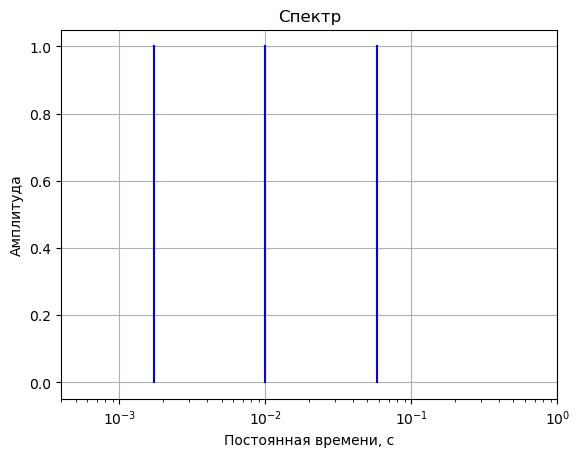

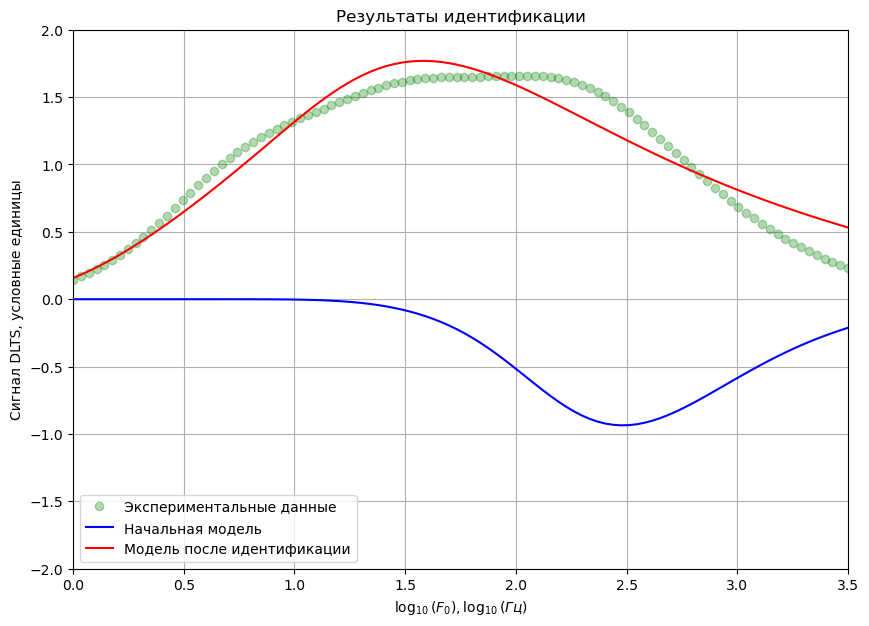

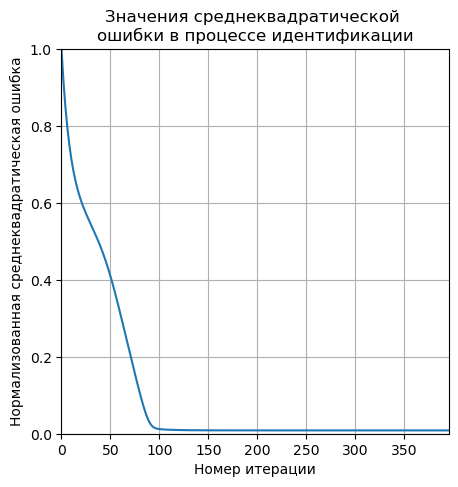

Спектр № 24
exps_params:
[[-2.8  1. ]
 [-2.   1. ]
 [-1.2  1. ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
24     1.710717        0.00002        True           0.05  0.021404       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
24     1000  0.318304  1.000000e-10            -1.930664    False  


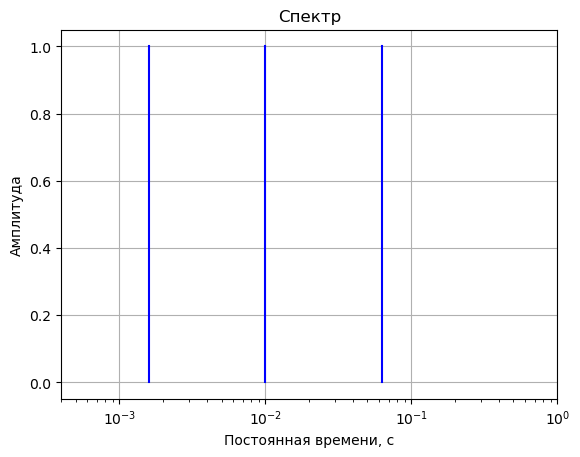

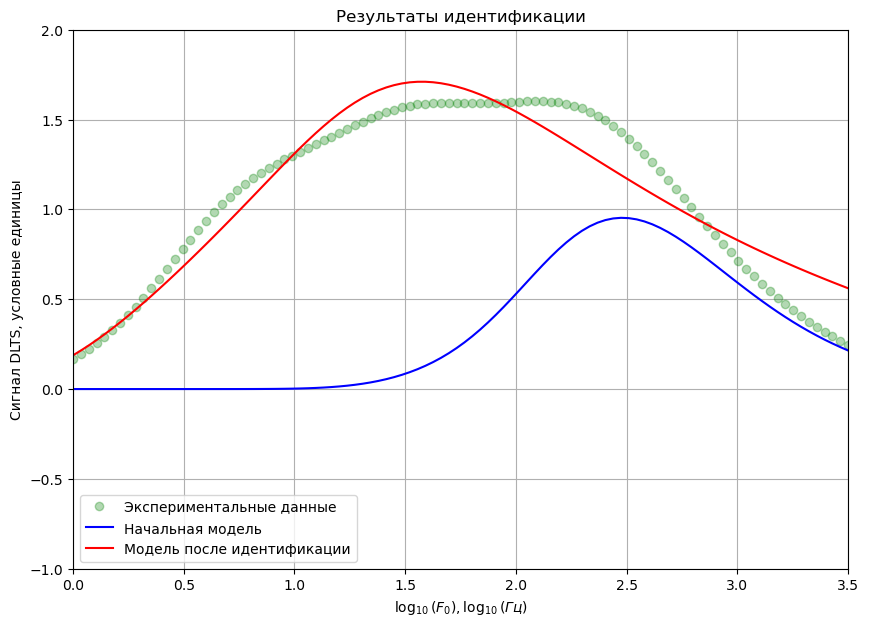

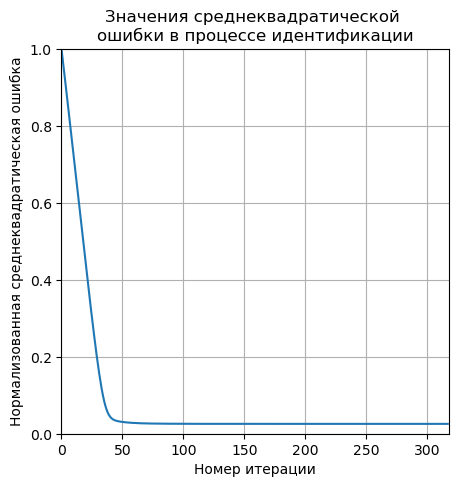

Спектр № 25
exps_params:
[[-2.83333333  1.        ]
 [-2.          1.        ]
 [-1.16666667  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
25     1.654337        0.00002        True           0.05  0.021592       1   

    n_iters   p_coef      stop_val  time_constant_pow_0  verbose  
25     1000  0.29328  1.000000e-10            -1.923477    False  


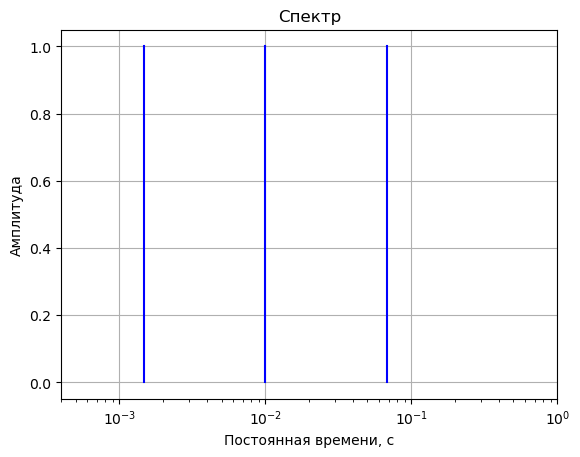

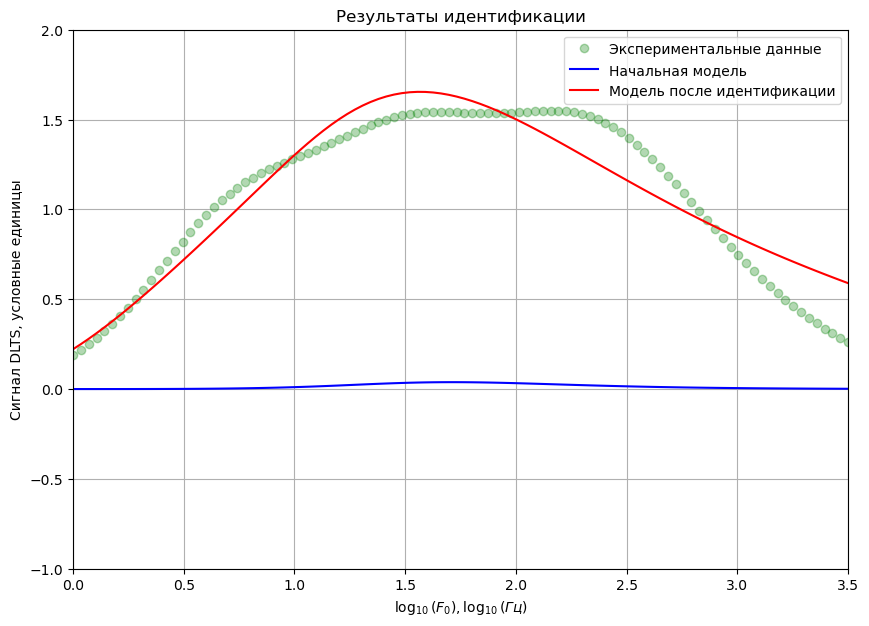

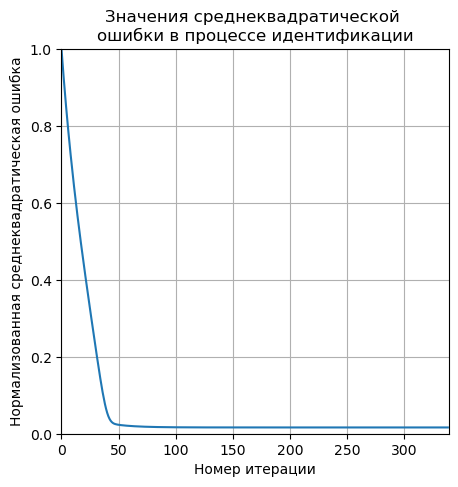

Спектр № 26
exps_params:
[[-2.86666667  1.        ]
 [-2.          1.        ]
 [-1.13333333  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
26     1.599799        0.00002        True           0.05  0.021553       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
26     1000  0.269356  1.000000e-10            -1.916331    False  


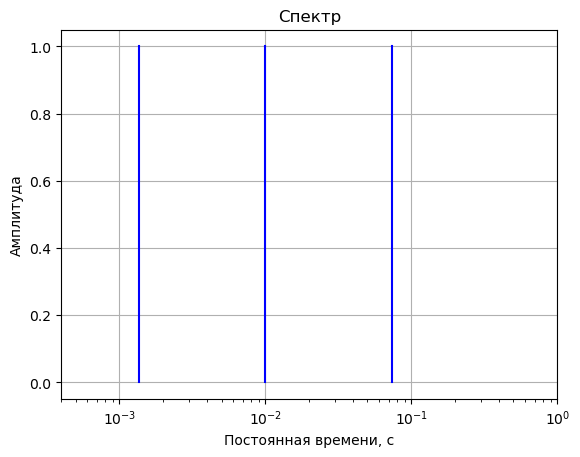

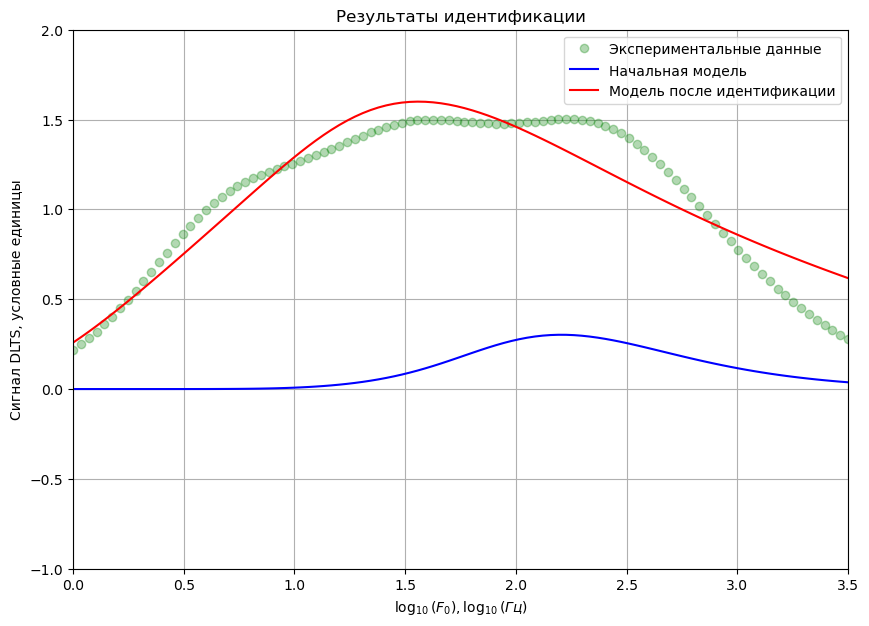

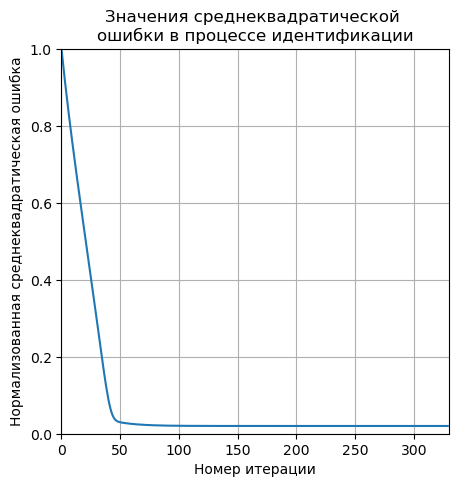

Спектр № 27
exps_params:
[[-2.9  1. ]
 [-2.   1. ]
 [-1.1  1. ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
27     1.547055        0.00002        True           0.05  0.021303       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
27     1000  0.246465  1.000000e-10            -1.909293    False  


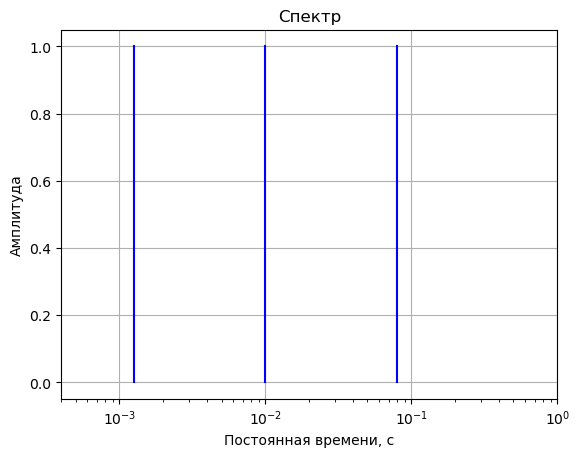

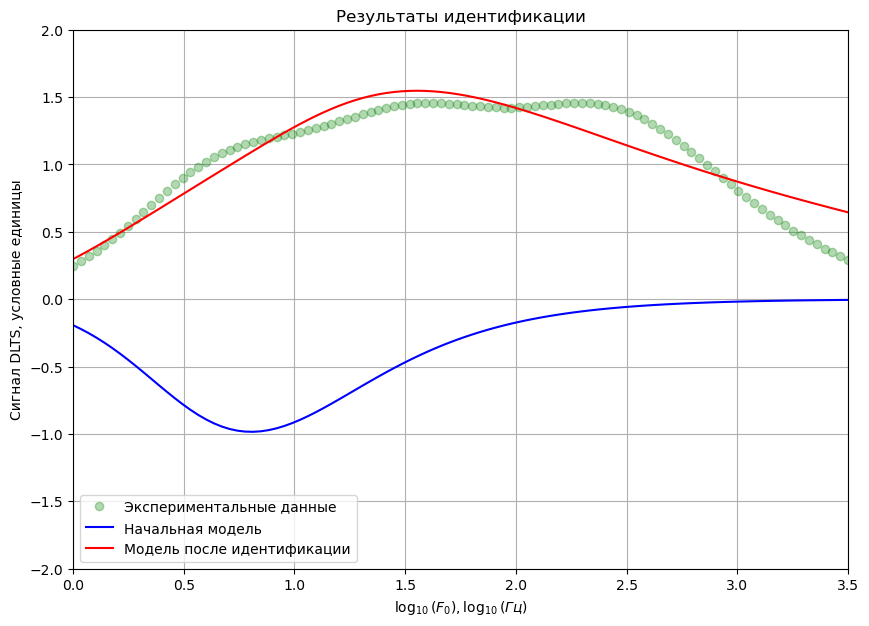

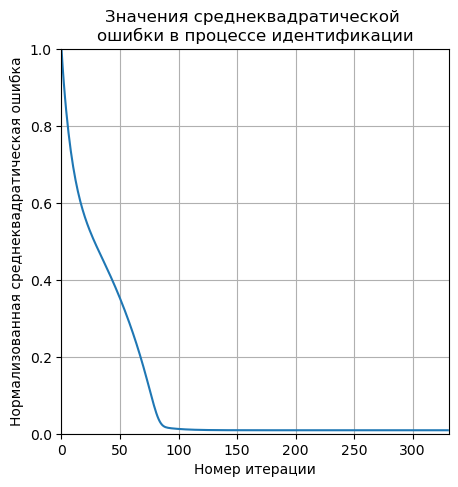

Спектр № 28
exps_params:
[[-2.93333333  1.        ]
 [-2.          1.        ]
 [-1.06666667  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
28      1.49605        0.00002        True           0.05  0.020866       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
28     1000  0.224535  1.000000e-10             -1.90249    False  


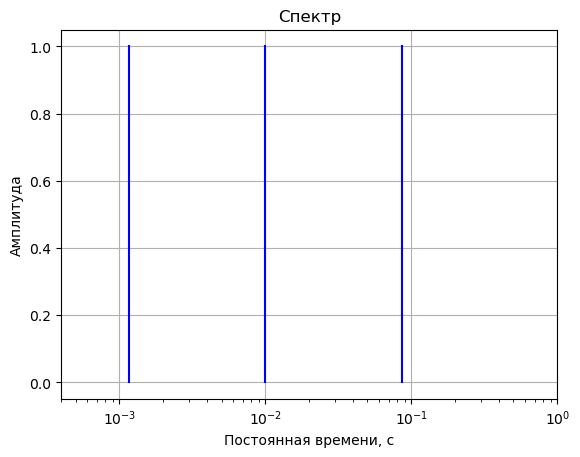

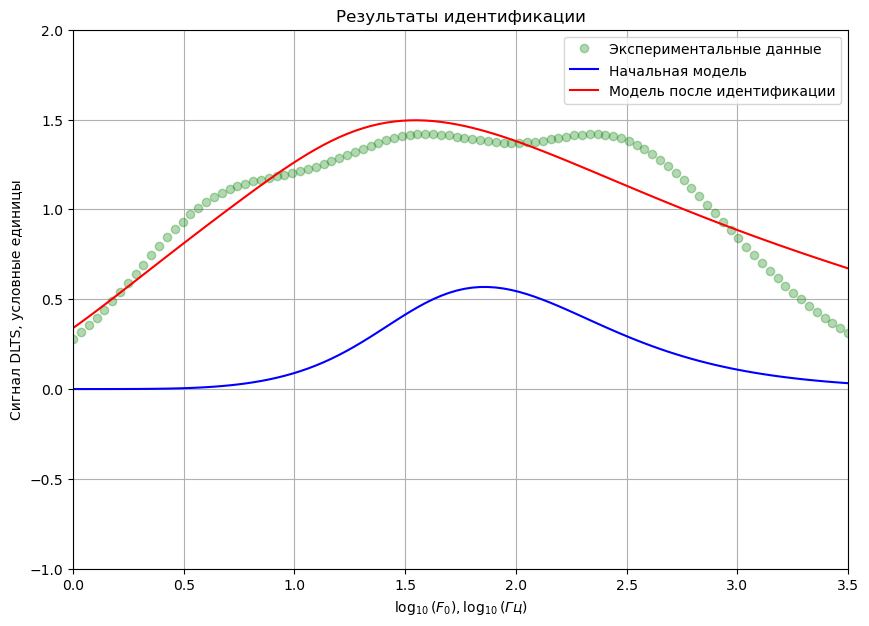

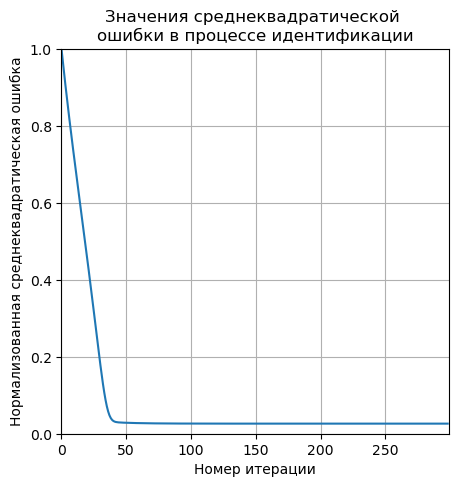

Спектр № 29
exps_params:
[[-2.96666667  1.        ]
 [-2.          1.        ]
 [-1.03333333  1.        ]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate      loss  n_exps  \
29     1.446716        0.00002        True           0.05  0.020268       1   

    n_iters    p_coef      stop_val  time_constant_pow_0  verbose  
29     1000  0.203504  1.000000e-10            -1.895968    False  


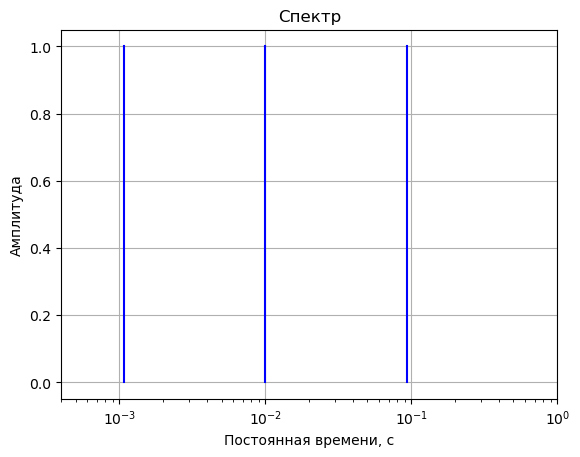

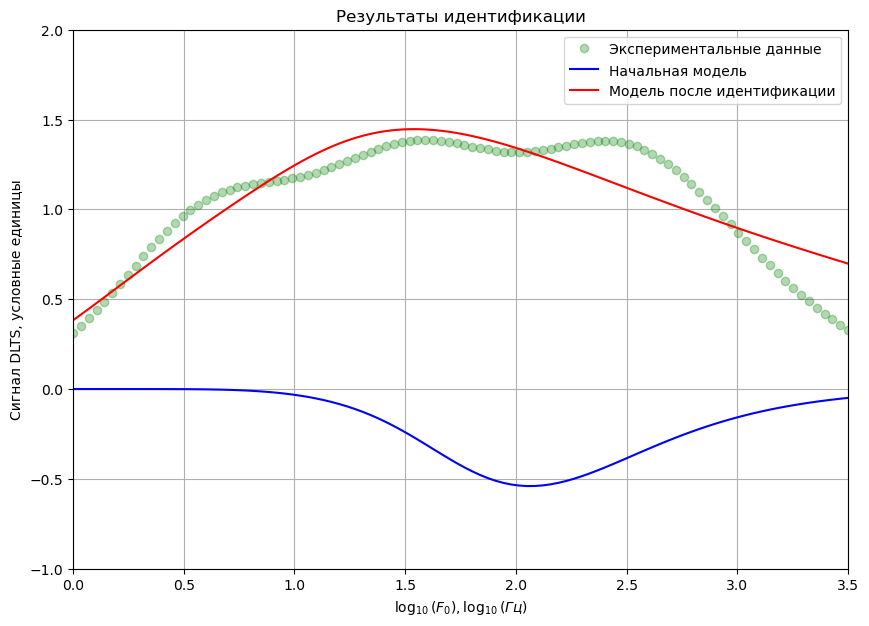

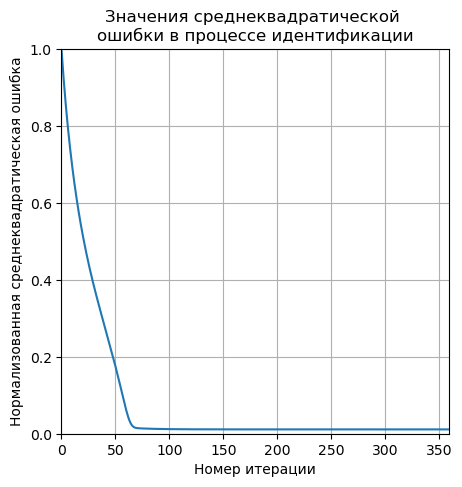

Спектр № 30
exps_params:
[[-3.  1.]
 [-2.  1.]
 [-1.  1.]]
Результаты идентификации:
    amplitude_0  filling_pulse  fit_p_coef  learning_rate     loss  n_exps  \
30     1.398972        0.00002        True           0.05  0.01954       1   

    n_iters   p_coef      stop_val  time_constant_pow_0  verbose  
30     1000  0.18331  1.000000e-10            -1.889832    False  


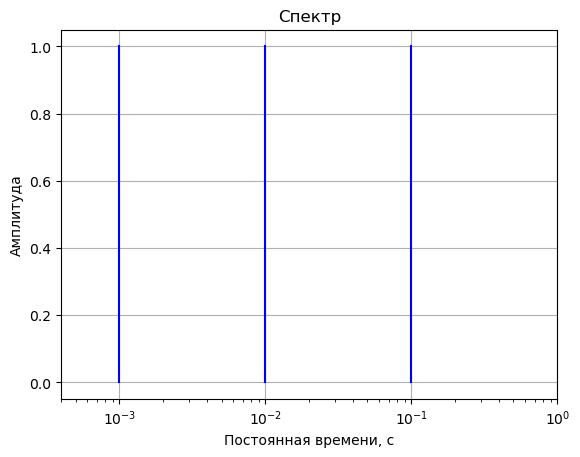

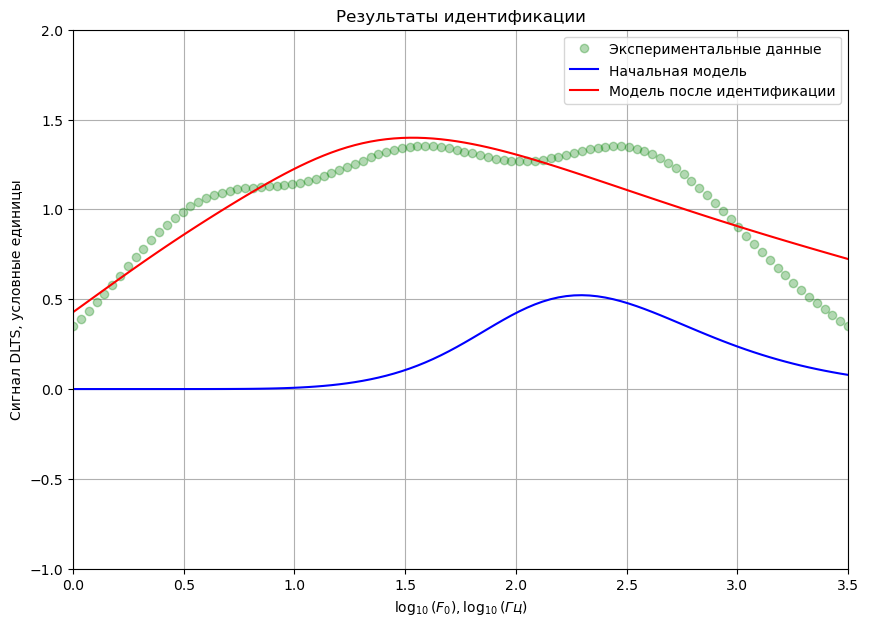

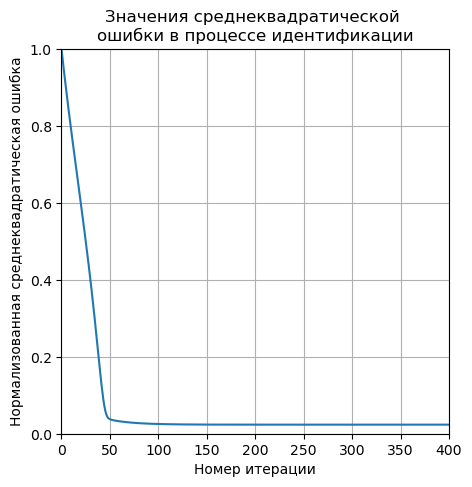

In [13]:
batch_plot(frequency_powers = FREQUENCY_POWERS, 
           experimental_values = test_data, 
           exps_params = exps_params,
           identification_results = identification_results,
           f_pulse = F_PULSE,
           save_to = '../plots/3-exp-clear/'
          )

## Зависимость $p$ от расстояния между линиями на спектре

In [14]:
def plot_p(exps_params, final_params, save_to=None):
    plt.figure(figsize=(10,7))

    max_dev = 10 ** exps_params[:, -1, 0] - 10 ** exps_params[:, 0, 0]
    plt.plot(max_dev, final_params.p_coef.to_numpy())
    plt.title('Зависимость коэффициента $p$ от расстояния между линиями на спектре')
    plt.xlabel(r'$\tau_0 - \tau_2$')
    plt.ylabel('Коэффициент $p$')
    plt.grid()

    if save_to is not None:
        plt.savefig(save_to + 'p_func.pdf', bbox_inches='tight')

    plt.show()

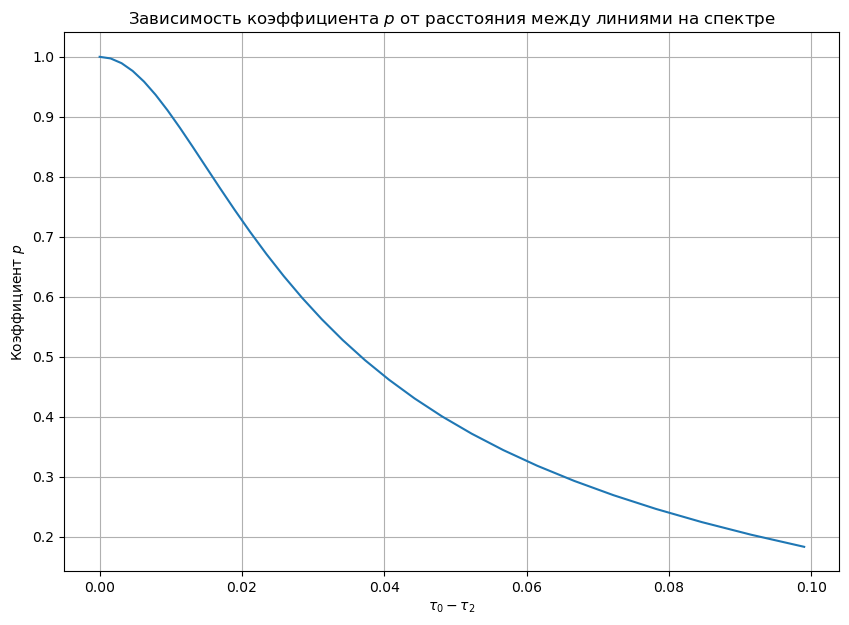

In [15]:
plot_p(exps_params=exps_params, 
       final_params=identification_results['final_params'], 
       save_to = '../plots/3-exp-clear/')